In [1]:
!pip install facenet-pytorch
!pip install ultralytics
!pip install mediapipe
!pip install opencv-python-headless
!pip install opencv-contrib-python
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install tqdm
!pip install dash
!pip install plotly
!pip install dash-bootstrap-components
!pip install ipywidgets

  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 6.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 7.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 2.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.3 MB/s eta 0:00:00a 0:00:01
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 1.5 MB/s eta 0:00:00-:--:--
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.1.0
    Uninstalling pillow-11.1.0:
      Successfully uninstalled pillow-11.1.0
  Attempting uninstall: numpy
    Fou

In [18]:
import os
import sys
import time
import io
import base64
import pickle
import json
import warnings
import subprocess
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


from facenet_pytorch import MTCNN, InceptionResnetV1
from ultralytics import YOLO
import mediapipe as mp

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML, clear_output
from tqdm.notebook import tqdm

import subprocess
import sys
import warnings


# Cấu hình cảnh báo
warnings.filterwarnings('ignore')

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cpu


In [14]:
# 1. Module phát hiện khuôn mặt (FaceDetector)

class FaceDetector:
    def __init__(self, method='mtcnn', device='cpu', confidence_threshold=0.5, nms_threshold=0.5, min_face_size=20):
        """
        Khởi tạo bộ phát hiện khuôn mặt

         Tham số:
            method (str): Phương pháp phát hiện khuôn mặt ('mtcnn' hoặc 'yolov8')
            device (str): Thiết bị để chạy mô hình ('cuda' hoặc 'cpu')
            confidence_threshold (float): Ngưỡng độ tin cậy để lọc các phát hiện
            nms_threshold (float): Ngưỡng NMS để loại bỏ các phát hiện trùng lặp
            min_face_size (int): Kích thước khuôn mặt tối thiểu để phát hiện (pixel
        """
        self.method = method
        self.device = device
        self.confidence_threshold = confidence_threshold
        self.nms_threshold = nms_threshold
        self.min_face_size = min_face_size
        
        if method == 'mtcnn':
            self.detector = MTCNN(keep_all=True, device=device, min_face_size=min_face_size)
        elif method == 'yolov8':
            from ultralytics import YOLO
            self.detector = YOLO('yolov8n-face.pt')
        else:
            raise ValueError(f"Phương pháp phát hiện khuôn mặt không được hỗ trợ: {method}")

    def _apply_nms(self, boxes, probs, iou_threshold):
        """
        Áp dụng Non-Maximum Suppression để loại bỏ các phát hiện trùng lặp

        Tham số:
            boxes (numpy.ndarray): Ma trận chứa các hộp giới hạn [x1, y1, x2, y2]
            probs (numpy.ndarray): Mảng chứa độ tin cậy cho mỗi khuôn mặt
            iou_threshold (float): Ngưỡng IoU để loại bỏ các phát hiện trùng lặp

        Trả về:
            boxes (numpy.ndarray): Ma trận chứa các hộp giới hạn sau khi áp dụng NMS
            probs (numpy.ndarray): Mảng chứa độ tin cậy tương ứng
        """
        if len(boxes) == 0:
            return np.array([]), np.array([])

        # Sắp xếp các hộp theo độ tin cậy giảm dần
        sorted_indices = np.argsort(probs)[::-1]
        boxes_sorted = boxes[sorted_indices]
        probs_sorted = probs[sorted_indices]

        keep_indices = []

        while len(boxes_sorted) > 0:
            # Giữ lại hộp có độ tin cậy cao nhất
            keep_indices.append(sorted_indices[0])

            if len(boxes_sorted) == 1:
                break

            # Tính IoU giữa hộp đầu tiên và tất cả các hộp còn lại
            ious = self._calculate_ious(boxes_sorted[0], boxes_sorted[1:])

            # Lọc ra các hộp có IoU nhỏ hơn ngưỡng
            mask = ious < iou_threshold
            boxes_sorted = boxes_sorted[1:][mask]
            probs_sorted = probs_sorted[1:][mask]
            sorted_indices = sorted_indices[1:][mask]

        return boxes[keep_indices], probs[keep_indices]

    def _adjust_flipped_boxes(self, boxes, height, width):
        """
        Điều chỉnh tọa độ boxes sau khi lật ngang

        Tham số:
            boxes (numpy.ndarray): Ma trận chứa các hộp giới hạn [x1, y1, x2, y2]
            height (int): Chiều cao của ảnh
            width (int): Chiều rộng của ảnh

        Trả về:
            numpy.ndarray: Ma trận chứa các hộp giới hạn đã điều chỉnh
        """
        adjusted_boxes = boxes.copy()
        adjusted_boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
        return adjusted_boxes

    def detect_faces(self, frame, scale_factor=1.0):
        """
        Phát hiện khuôn mặt trong một khung hình

        Tham số:
            frame (numpy.ndarray): Hình ảnh BGR từ OpenCV
            scale_factor (float): Tỷ lệ thay đổi kích thước ảnh để cải thiện phát hiện

        Trả về:
            boxes (numpy.ndarray): Ma trận chứa các hộp giới hạn [x1, y1, x2, y2]
            probs (numpy.ndarray): Mảng chứa độ tin cậy cho mỗi khuôn mặt
        """
        global probs, boxes
        if scale_factor != 1.0:
            h, w = frame.shape[:2]
            new_h, new_w = int(h * scale_factor), int(w * scale_factor)
            resized_frame = cv2.resize(frame, (new_w, new_h))
        else:
            resized_frame = frame

        rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

        if self.method == 'mtcnn':
            boxes, probs = self.detector.detect(rgb_frame)

            if boxes is None:
                return np.array([]), np.array([])

            if len(probs) > 0:
                mask = probs >= self.confidence_threshold
                boxes = boxes[mask]
                probs = probs[mask]
        elif self.method == 'yolov8':
            results = self.detector.detect(rgb_frame)
            boxes = results[0].boxes.xyxy.cpu().numpy()
            probs = results[0].probs.cpu().numpy()

            if len(probs) > 0:
                mask = probs >= self.confidence_threshold
                boxes = boxes[mask]
                probs = probs[mask]

        # Điều chỉnh lại tọa độ nếu đã thay đổi kích thước
        if scale_factor != 1.0 and len(boxes) > 0:
            boxes = boxes / scale_factor

        if len(boxes) > 0:
            boxes, probs = self._apply_mns(boxes, probs, self.nms_threshold)

        return boxes, probs

    def detect_faces_with_augmentation(self, frame):
        """
        Phát hiện khuôn mặt với các kỹ thuật tăng cường để cải thiện độ chính xác

        Tham số:
            frame (numpy.ndarray): Hình ảnh BGR từ OpenCV

        Trả về:
            boxes (numpy.ndarray): Ma trận chứa các hộp giới hạn [x1, y1, x2, y2]
            probs (numpy.ndarray): Mảng chứa độ tin cậy cho mỗi khuôn mặt
        """
        # Phát hiện trên khung hình gốc
        boxes, probs = self.detect_faces(frame)

        # Danh sách các phép biến đổi
        augmentations = [
            # Lật ngang
            (lambda f: cv2.flip(f, 1), self._adjust_flipped_boxes),
            # Thay đổi độ sáng
            (lambda f: cv2.convertScaleAbs(f, alpha=1.1, beta=10), None),
            # Thay đổi tỷ lệ
            (lambda f: cv2.resize(f, None, fx=0.8, fy=0.8),
             lambda b, h, w: b * 1.25)  # Điều chỉnh ngược lại tỷ lệ
        ]

        all_boxes = boxes.copy() if len(boxes) > 0 else np.array([])
        all_probs = probs.copy() if len(probs) > 0 else np.array([])

        # Áp dụng các phép biến đổi và phát hiện
        for aug_func, box_adjust_func in augmentations:
            aug_frame = aug_func(frame)
            aug_boxes, aug_probs = self.detect_faces(aug_frame)

            # Điều chỉnh tọa độ nếu cần
            if len(aug_boxes) > 0 and box_adjust_func is not None:
                h, w = frame.shape[:2]
                aug_boxes = box_adjust_func(aug_boxes, h, w)

            # Gộp kết quả
            if len(aug_boxes) > 0:
                all_boxes = np.vstack([all_boxes, aug_boxes]) if len(all_boxes) > 0 else aug_boxes
                all_probs = np.concatenate([all_probs, aug_probs]) if len(all_probs) > 0 else aug_probs

        # Áp dụng NMS một lần nữa để loại bỏ các phát hiện trùng lặp
        if len(all_boxes) > 0:
            all_boxes, all_probs = self._apply_nms(all_boxes, all_probs, self.nms_threshold)

        return all_boxes, all_probs

    def evaluate(self, test_images, ground_truths, iou_threshold=0.5):
        """
        Đánh giá độ chính xác của bộ phát hiện khuôn mặt

        Tham số:
            test_images (list): Danh sách các ảnh kiểm thử
            ground_truths (list): Danh sách các ground truth boxes tương ứng
            iou_threshold (float): Ngưỡng IoU để coi một phát hiện là đúng

        Trả về:
            dict: Kết quả đánh giá với các độ đo Precision, Recall, F1-score và thông tin chi tiết
        """
        total_tp = 0  # True Positives
        total_fp = 0  # False Positives
        total_fn = 0  # False Negatives

        for frame, gt_boxes in zip(test_images, ground_truths):
            # Phát hiện khuôn mặt
            detected_boxes, _ = self.detect_faces(frame)

            # Tính toán TP, FP, FN
            tp, fp, fn = self._calculate_metrics(detected_boxes, gt_boxes, iou_threshold)

            total_tp += tp
            total_fp += fp
            total_fn += fn

        # Tính toán các độ đo đánh giá
        precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
        recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        # Tính Miss Rate và FPPI
        miss_rate = 1 - recall if recall > 0 else 1
        fppi = total_fp / len(test_images) if len(test_images) > 0 else 0

        # Tổng hợp kết quả
        evaluation_results = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'miss_rate': miss_rate,
            'fppi': fppi,
            'details': {
                'true_positives': total_tp,
                'false_positives': total_fp,
                'false_negatives': total_fn,
                'total_images': len(test_images)
            }
        }

        return evaluation_results

    def _calculate_metrics(self, detected_boxes, gt_boxes, iou_threshold):
        """
        Tính toán TP, FP, FN cho một ảnh

        Tham số:
            detected_boxes (numpy.ndarray): Ma trận chứa các hộp giới hạn được phát hiện
            gt_boxes (numpy.ndarray): Ma trận chứa các hộp giới hạn ground truth
            iou_threshold (float): Ngưỡng IoU để coi một phát hiện là đúng

        Trả về:
            tp (int): Số lượng True Positives
            fp (int): Số lượng False Positives
            fn (int): Số lượng False Negatives
        """
        if len(detected_boxes) == 0:
            return 0, 0, len(gt_boxes)

        if len(gt_boxes) == 0:
            return 0, len(detected_boxes), 0

        # Tính ma trận IoU giữa detected_boxes và gt_boxes
        ious = np.zeros((len(detected_boxes), len(gt_boxes)))

        for i, detected_box in enumerate(detected_boxes):
            for j, gt_box in enumerate(gt_boxes):
                ious[i, j] = self._calculate_iou(detected_box, gt_box)

        # Tìm các cặp matching tốt nhất
        matched_indices = []
        gt_matched = [False] * len(gt_boxes)

        # Sắp xếp theo độ tin cậy giảm dần (giả định các box được sắp xếp theo độ tin cậy)
        for i in range(len(detected_boxes)):
            # Tìm ground truth có IoU cao nhất với box này
            best_j = -1
            best_iou = iou_threshold

            for j in range(len(gt_boxes)):
                if not gt_matched[j] and ious[i, j] > best_iou:
                    best_j = j
                    best_iou = ious[i, j]

            if best_j >= 0:
                matched_indices.append((i, best_j))
                gt_matched[best_j] = True

        tp = len(matched_indices)  # True Positives
        fp = len(detected_boxes) - tp  # False Positives
        fn = len(gt_boxes) - tp  # False Negatives

        return tp, fp, fn

    def _calculate_iou(self, box1, box2):
        """
        Tính IoU giữa hai hộp

        Tham số:
            box1 (numpy.ndarray): Hộp giới hạn thứ nhất [x1, y1, x2, y2]
            box2 (numpy.ndarray): Hộp giới hạn thứ hai [x1, y1, x2, y2]

        Trả về:
            float: Giá trị IoU
        """
        # Tính tọa độ giao nhau
        intersect_x1 = max(box1[0], box2[0])
        intersect_y1 = max(box1[1], box2[1])
        intersect_x2 = min(box1[2], box2[2])
        intersect_y2 = min(box1[3], box2[3])

        # Tính diện tích giao nhau
        intersect_width = max(0, intersect_x2 - intersect_x1)
        intersect_height = max(0, intersect_y2 - intersect_y1)
        intersect_area = intersect_width * intersect_height

        # Tính diện tích từng hộp
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

        # Tính diện tích hợp
        union_area = box1_area + box2_area - intersect_area

        # Tính IoU
        iou = intersect_area / union_area if union_area > 0 else 0

        return iou

    def evaluate_precision(self, test_images, ground_truths, iou_threshold=0.5):
        """
        Đánh giá chỉ độ chính xác (Precision) của bộ phát hiện khuôn mặt

        Tham số:
            test_images (list): Danh sách các ảnh kiểm thử
            ground_truths (list): Danh sách các ground truth boxes tương ứng
            iou_threshold (float): Ngưỡng IoU để coi một phát hiện là đúng

        Trả về:
            float: Giá trị Precision
            dict: Thông tin chi tiết
        """
        total_tp = 0  # True Positives
        total_fp = 0  # False Positives

        for image, gt_boxes in zip(test_images, ground_truths):
            # Phát hiện khuôn mặt trong ảnh
            detected_boxes, _ = self.detect_faces(image)

            # Nếu không có ground truth boxes nào, tất cả phát hiện đều là false positives
            if len(gt_boxes) == 0:
                total_fp += len(detected_boxes)
                continue

            # Nếu không có phát hiện nào, bỏ qua ảnh này
            if len(detected_boxes) == 0:
                continue

            # Khởi tạo mảng đánh dấu ground truth đã được ghép cặp
            gt_matched = [False] * len(gt_boxes)

            # Duyệt qua từng khuôn mặt được phát hiện
            for box in detected_boxes:
                # Tìm ground truth box có IoU cao nhất với box được phát hiện
                max_iou = 0
                max_idx = -1

                for j, gt_box in enumerate(gt_boxes):
                    # Tính IoU giữa box được phát hiện và ground truth box
                    iou = self._calculate_iou(box, gt_box)

                    # Cập nhật max_iou và max_idx nếu tìm thấy IoU cao hơn
                    if iou > max_iou:
                        max_iou = iou
                        max_idx = j

                # Nếu IoU cao nhất vượt qua ngưỡng và ground truth chưa được ghép cặp
                if max_iou >= iou_threshold and max_idx >= 0 and not gt_matched[max_idx]:
                    total_tp += 1  # Tăng số lượng true positives
                    gt_matched[max_idx] = True  # Đánh dấu ground truth đã được ghép cặp
                else:
                    total_fp += 1  # Tăng số lượng false positives

        # Tính toán Precision
        precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0

        # Trả về Precision và thông tin chi tiết
        details = {
            'true_positives': total_tp,
            'false_positives': total_fp,
            'total_detections': total_tp + total_fp
        }

        return precision, details

In [15]:
# Hàm trợ giúp để đo thời gian xử lý
def measure_fps(face_detector, test_images, num_runs=10):
    """
    Đo tốc độ xử lý của bộ phát hiện khuôn mặt (FPS)

    Tham số:
        face_detector (FaceDetector): Bộ phát hiện khuôn mặt cần đánh giá
        test_images (list): Danh sách các ảnh kiểm thử
        num_runs (int): Số lần chạy để lấy giá trị trung bình

    Trả về:
        float: Tốc độ xử lý trung bình (frames per second)
    """
    import time

    total_time = 0
    total_frames = len(test_images) * num_runs

    for _ in range(num_runs):
        for image in test_images:
            start_time = time.time()
            face_detector.detect_faces(image)
            end_time = time.time()
            total_time += (end_time - start_time)

    fps = total_frames / total_time if total_time > 0 else 0
    return fps

In [38]:
# 2. Module trích xuất đặc trưng khuôn mặt (FaceFeatureExtractor)
class FaceFeatureExtractor:
    """
    Lớp FaceFeatureExtractor - Trích xuất đặc trưng từ khuôn mặt đã phát hiện
    
    Lớp này hỗ trợ nhiều phương pháp khác nhau để trích xuất đặc trưng khuôn mặt:
    1. 'resnet': Sử dụng mô hình InceptionResnetV1 được huấn luyện trước trên tập dữ liệu VGGFace2 
                để tạo ra embedding 512 chiều cho mỗi khuôn mặt
    2. 'mediapipe': Sử dụng MediaPipe Face Mesh để phát hiện 468 landmarks trên khuôn mặt
                    và tính toán các đặc trưng hình học (tỷ lệ mở mắt, miệng, hướng nhìn)
    3. 'custom': Dành cho triển khai tùy chỉnh (chưa triển khai)
    """
    
    def __init__(self, method='resnet', device=device):
        """
        Khởi tạo bộ trích xuất đặc trưng khuôn mặt

        Tham số:
            method (str): Phương pháp trích xuất đặc trưng ('resnet', 'mediapipe', 'custom')
            device (str): Thiết bị để chạy mô hình ('cuda' hoặc 'cpu')
        
        Raises:
            ImportError: Nếu các thư viện cần thiết không thể cài đặt
            RuntimeError: Nếu khởi tạo mô hình không thành công
        """
        self.method = method
        self.device = device
        print(f"Khởi tạo FaceFeatureExtractor với phương pháp: {method}")

        if method == 'resnet':
            # Kiểm tra và cài đặt facenet-pytorch nếu cần
            try:
                from facenet_pytorch import InceptionResnetV1
                print("Đã tìm thấy thư viện facenet-pytorch")
            except ImportError:
                print("Đang cài đặt facenet-pytorch...")
                try:
                    subprocess.check_call([sys.executable, "-m", "pip", "install", "facenet-pytorch"])
                    from facenet_pytorch import InceptionResnetV1
                    print("Đã cài đặt facenet-pytorch thành công")
                except Exception as e:
                    raise ImportError(f"Không thể cài đặt facenet-pytorch: {e}")
                
            # Cài đặt PIL (Pillow) nếu chưa có
            try:
                import PIL
                print("Đã tìm thấy thư viện Pillow")
            except ImportError:
                print("Đang cài đặt Pillow...")
                try:
                    subprocess.check_call([sys.executable, "-m", "pip", "install", "Pillow"])
                    print("Đã cài đặt Pillow thành công")
                except Exception as e:
                    raise ImportError(f"Không thể cài đặt Pillow: {e}")
                
            # Khởi tạo mô hình InceptionResnetV1 với pre-trained weights từ VGGFace2
            try:
                print("Đang tải mô hình InceptionResnetV1 (pretrained='vggface2')...")
                self.model = InceptionResnetV1(pretrained='vggface2').to(device).eval()
                print("Đã tải mô hình InceptionResnetV1 thành công")
            except Exception as e:
                raise RuntimeError(f"Không thể tải mô hình InceptionResnetV1: {e}")
                
        elif method == 'mediapipe':
            # Kiểm tra và cài đặt mediapipe nếu cần
            try:
                import mediapipe as mp
                print("Đã tìm thấy thư viện mediapipe")
            except ImportError:
                print("Đang cài đặt mediapipe...")
                try:
                    subprocess.check_call([sys.executable, "-m", "pip", "install", "mediapipe"])
                    import mediapipe as mp
                    print("Đã cài đặt mediapipe thành công")
                except Exception as e:
                    raise ImportError(f"Không thể cài đặt mediapipe: {e}")
                
            # Khởi tạo MediaPipe Face Mesh
            try:
                self.mp_face_mesh = mp.solutions.face_mesh
                self.face_mesh = self.mp_face_mesh.FaceMesh(
                    max_num_faces=1,              # Chỉ xử lý 1 khuôn mặt mỗi lần
                    refine_landmarks=True,        # Sử dụng mô hình tinh chỉnh landmarks bổ sung
                    min_detection_confidence=0.5, # Ngưỡng tin cậy cho phát hiện khuôn mặt
                    min_tracking_confidence=0.5   # Ngưỡng tin cậy cho theo dõi khuôn mặt
                )
                print("Đã khởi tạo MediaPipe Face Mesh thành công")
            except Exception as e:
                raise RuntimeError(f"Không thể khởi tạo MediaPipe Face Mesh: {e}")
                
        else:
            # Custom feature extractor
            print("Phương pháp 'custom' được chọn nhưng chưa được triển khai")
            pass

    def extract_features(self, frame, boxes):
        """
        Trích xuất đặc trưng từ các khuôn mặt đã phát hiện trong hình ảnh
        
        Đối với phương pháp 'resnet':
        - Cắt khuôn mặt dựa trên bounding box
        - Tiền xử lý ảnh (resize, chuẩn hóa)
        - Truyền qua mô hình InceptionResnetV1 để lấy embedding 512 chiều
        
        Đối với phương pháp 'mediapipe':
        - Phát hiện 468 landmarks trên khuôn mặt
        - Tính toán các đặc trưng hình học như:
          + Tỷ lệ mở mắt (Eye Aspect Ratio - EAR)
          + Tỷ lệ mở miệng (Mouth Aspect Ratio - MAR)
          + Hướng nhìn (Gaze Direction)

        Tham số:
            frame (numpy.ndarray): Hình ảnh BGR từ OpenCV
            boxes (numpy.ndarray): Ma trận chứa các hộp giới hạn [x1, y1, x2, y2]

        Trả về:
            features (list): Danh sách các vector đặc trưng cho mỗi khuôn mặt
                            - Với 'resnet': Mỗi vector có 512 chiều
                            - Với 'mediapipe': Mỗi vector có 4 chiều (EAR, MAR, gaze_x, gaze_y)
                            - None cho các khuôn mặt không thể trích xuất đặc trưng
        """
        if len(boxes) == 0:
            print("Không tìm thấy khuôn mặt nào để trích xuất đặc trưng")
            return []

        features = []
        print(f"Trích xuất đặc trưng cho {len(boxes)} khuôn mặt với phương pháp '{self.method}'")

        if self.method == 'resnet':
            for i, box in enumerate(boxes):
                # Cắt khuôn mặt
                try:
                    x1, y1, x2, y2 = box.astype(int)
                    # Đảm bảo tọa độ nằm trong kích thước hình ảnh
                    h, w = frame.shape[:2]
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w, x2), min(h, y2)
                    
                    face = frame[y1:y2, x1:x2]

                    if face.size == 0 or face.shape[0] == 0 or face.shape[1] == 0:
                        print(f"Khuôn mặt #{i+1}: Kích thước không hợp lệ - box={[x1, y1, x2, y2]}")
                        features.append(None)
                        continue

                    # Chuyển đổi sang RGB
                    face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

                    # Resize và tiền xử lý
                    # Chuyển ảnh NumPy sang PIL Image
                    # Resize ảnh về kích thước 160x160 (yêu cầu của InceptionResnetV1)
                    # Chuyển sang tensor
                    # Chuẩn hóa giá trị pixel về phạm vi [-1, 1]
                    transform = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize((160, 160)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                    ])

                    face_tensor = transform(face_rgb).unsqueeze(0).to(self.device)
                    
                    # Tắt gradient trong quá trình inference để tăng tốc và tiết kiệm bộ nhớ
                    with torch.no_grad():
                        # Lấy embedding 512 chiều
                        embedding = self.model(face_tensor).cpu().numpy()[0]
                    
                    print(f"Khuôn mặt #{i+1}: Đã trích xuất embedding có kích thước {embedding.shape}")
                    features.append(embedding)
                except Exception as e:
                    print(f"Lỗi khi trích xuất đặc trưng cho khuôn mặt #{i+1}: {e}")
                    features.append(None)

        elif self.method == 'mediapipe':
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            for i, box in enumerate(boxes):
                try:
                    x1, y1, x2, y2 = box.astype(int)
                    # Đảm bảo tọa độ nằm trong kích thước hình ảnh
                    h, w = frame.shape[:2]
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w, x2), min(h, y2)
                    
                    face = frame_rgb[y1:y2, x1:x2]

                    if face.size == 0 or face.shape[0] == 0 or face.shape[1] == 0:
                        print(f"Khuôn mặt #{i+1}: Kích thước không hợp lệ - box={[x1, y1, x2, y2]}")
                        features.append(None)
                        continue

                    # Phát hiện landmarks với MediaPipe Face Mesh
                    results = self.face_mesh.process(face)

                    if not results.multi_face_landmarks:
                        print(f"Khuôn mặt #{i+1}: Không thể phát hiện landmarks")
                        features.append(None)
                        continue

                    # Trích xuất tọa độ của 468 landmarks
                    face_landmarks = results.multi_face_landmarks[0]
                    landmarks = []

                    # Lấy tọa độ các điểm landmarks và chuyển từ tỷ lệ sang pixel
                    h, w, _ = face.shape
                    for landmark in face_landmarks.landmark:
                        x = landmark.x * w  # Chuyển từ tỷ lệ sang pixel
                        y = landmark.y * h  # Chuyển từ tỷ lệ sang pixel
                        landmarks.append([x, y])

                    # Chuyển đổi sang numpy array
                    landmarks = np.array(landmarks)
                    print(f"Khuôn mặt #{i+1}: Đã phát hiện {len(landmarks)} landmarks")

                    # Tính toán các đặc trưng hình học (EAR, MAR, hướng nhìn)
                    feature_vector = self._calculate_geometric_features(landmarks)
                    if feature_vector is not None:
                        print(f"Khuôn mặt #{i+1}: Đã tính toán vector đặc trưng có kích thước {feature_vector.shape}")
                    features.append(feature_vector)
                except Exception as e:
                    print(f"Lỗi khi trích xuất đặc trưng MediaPipe cho khuôn mặt #{i+1}: {e}")
                    features.append(None)

        return features

    def _calculate_geometric_features(self, landmarks):
        """
        Tính toán các đặc trưng hình học từ landmarks MediaPipe
        
        MediaPipe Face Mesh cung cấp 468 landmarks chi tiết trên khuôn mặt.
        Hàm này tính toán các đặc trưng hình học hữu ích từ các landmarks:
        
        1. Tỷ lệ mở mắt (Eye Aspect Ratio - EAR):
           - Tỷ lệ giữa chiều cao và chiều rộng của mắt
           - Giá trị thấp khi mắt nhắm, cao khi mắt mở
        
        2. Tỷ lệ mở miệng (Mouth Aspect Ratio - MAR):
           - Tỷ lệ giữa chiều cao và chiều rộng của miệng
           - Giá trị thấp khi miệng đóng, cao khi miệng mở
        
        3. Hướng nhìn (Gaze Direction):
           - Hướng của vector từ trung tâm hai mắt đến mũi
           - Giúp xác định hướng nhìn của khuôn mặt

        Tham số:
            landmarks (numpy.ndarray): Ma trận chứa tọa độ các landmarks (468, 2)

        Trả về:
            features (numpy.ndarray): Vector đặc trưng hình học (4,)
            
        Chi tiết chỉ số landmarks (tham khảo: https://github.com/tensorflow/tfjs-models/blob/master/face-landmarks-detection/src/mediapipe-facemesh/keypoints.ts):
        - Mắt trái: #33
        - Mắt phải: #263
        - Đỉnh miệng: #13
        - Đáy miệng: #14
        - Mũi: #4
        - Phần trên mắt trái: #159
        - Phần dưới mắt trái: #145
        - Phần trên mắt phải: #386
        - Phần dưới mắt phải: #374
        """
        if len(landmarks) == 0:
            print("Không có landmarks để tính toán đặc trưng hình học")
            return None

        try:
            # Điểm mắt (MediaPipe Face Mesh)
            left_eye = landmarks[33]     # Điểm giữa mắt trái
            right_eye = landmarks[263]   # Điểm giữa mắt phải

            # Điểm miệng
            top_lip = landmarks[13]      # Điểm trên miệng
            bottom_lip = landmarks[14]   # Điểm dưới miệng

            # Điểm mũi
            nose_tip = landmarks[4]

            # Tính tỷ lệ mở mắt (Eye Aspect Ratio - EAR)
            # Lấy điểm trên và dưới mắt
            left_eye_top = landmarks[159]      # Điểm trên mắt trái
            left_eye_bottom = landmarks[145]   # Điểm dưới mắt trái
            right_eye_top = landmarks[386]     # Điểm trên mắt phải
            right_eye_bottom = landmarks[374]  # Điểm dưới mắt phải

            # Tính khoảng cách theo tỷ lệ với khoảng cách giữa hai mắt
            # Chuẩn hóa theo khoảng cách giữa hai mắt giúp kết quả không phụ thuộc vào kích thước khuôn mặt
            eye_distance = np.linalg.norm(left_eye - right_eye)
            
            left_ear = np.linalg.norm(left_eye_top - left_eye_bottom) / eye_distance
            right_ear = np.linalg.norm(right_eye_top - right_eye_bottom) / eye_distance
            avg_ear = (left_ear + right_ear) / 2  # Lấy trung bình của hai mắt

            # Tính tỷ lệ mở miệng (Mouth Aspect Ratio - MAR)
            # Chuẩn hóa theo khoảng cách giữa hai mắt
            mar = np.linalg.norm(top_lip - bottom_lip) / eye_distance

            # Tính độ nghiêng đầu (Head Pose) và hướng nhìn (Gaze Direction)
            # Xác định bằng vector từ điểm giữa hai mắt đến mũi
            eye_center = (left_eye + right_eye) / 2  # Điểm giữa hai mắt
            gaze_vector = nose_tip - eye_center
            
            # Chuẩn hóa vector để có độ dài bằng 1 (đơn vị hóa)
            gaze_norm = np.linalg.norm(gaze_vector)
            if gaze_norm > 0:
                gaze_direction = gaze_vector / gaze_norm
            else:
                gaze_direction = np.array([0.0, 0.0])

            # Tạo vector đặc trưng 4 chiều
            features = np.array([
                avg_ear,              # Tỷ lệ mở mắt (càng lớn càng mở)
                mar,                  # Tỷ lệ mở miệng (càng lớn càng mở)
                gaze_direction[0],    # Hướng nhìn theo trục x
                gaze_direction[1],    # Hướng nhìn theo trục y
            ])

            return features
            
        except Exception as e:
            print(f"Lỗi trong quá trình tính toán đặc trưng hình học: {e}")
            return None

In [39]:
# Mô hình phân loại trạng thái chú ý và tạo dữ liệu tổng hợp
# 3. Mô hình phân loại trạng thái chú ý
class AttentionClassifier:
    """
    Lớp AttentionClassifier - Phân loại trạng thái chú ý của người dùng
    
    Lớp này xây dựng và sử dụng các mô hình học máy để phân loại trạng thái chú ý
    dựa trên các vector đặc trưng đã trích xuất từ khuôn mặt (từ FaceFeatureExtractor).
    
    Các trạng thái có thể phân loại:
    - 'Chú ý': Người dùng đang tập trung vào nội dung
    - 'Mất tập trung': Người dùng không tập trung, mắt nhìn đi nơi khác
    - 'Buồn ngủ': Người dùng đang buồn ngủ, mắt nhắm một phần
    
    Hỗ trợ nhiều loại mô hình khác nhau:
    - RandomForest: Tốt cho dữ liệu không tuyến tính, ít yêu cầu tiền xử lý
    - SVM: Hiệu quả với dữ liệu có số chiều cao, tốt cho phân loại nhị phân
    - Neural Network: Mô hình linh hoạt cho bài toán phức tạp
    """
    
    def __init__(self, model_type='random_forest', model_path=None):
        """
        Khởi tạo mô hình phân loại trạng thái chú ý

        Tham số:
            model_type (str): Loại mô hình ('random_forest', 'svm', 'neural_network')
            model_path (str): Đường dẫn đến mô hình đã lưu (nếu có)
        
        Raises:
            ImportError: Nếu các thư viện cần thiết không thể cài đặt
            ValueError: Nếu loại mô hình không được hỗ trợ
        """
        self.model_type = model_type
        self.model = None
        self.scaler = None  # Lưu lại scaler để áp dụng cho dữ liệu mới
        self.classes = ['Chú ý', 'Mất tập trung', 'Buồn ngủ']
        print(f"Khởi tạo AttentionClassifier với loại mô hình: {model_type}")

        # Cài đặt scikit-learn nếu cần
        try:
            import sklearn
            print(f"Đã tìm thấy scikit-learn phiên bản {sklearn.__version__}")
        except ImportError:
            print("Đang cài đặt scikit-learn...")
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
                import sklearn
                print(f"Đã cài đặt scikit-learn phiên bản {sklearn.__version__}")
            except Exception as e:
                raise ImportError(f"Không thể cài đặt scikit-learn: {e}")

        # Tải mô hình đã lưu nếu có
        if model_path and os.path.exists(model_path):
            print(f"Đang tải mô hình từ {model_path}")
            self.load_model(model_path)
        else:
            print("Khởi tạo mô hình mới")
            if model_type == 'random_forest':
                try:
                    from sklearn.ensemble import RandomForestClassifier
                    self.model = RandomForestClassifier(
                        n_estimators=100,   # Số cây quyết định trong rừng
                        max_depth=10,       # Độ sâu tối đa của mỗi cây
                        min_samples_split=5,  # Số mẫu tối thiểu để phân tách nút
                        min_samples_leaf=2,   # Số mẫu tối thiểu ở mỗi lá
                        random_state=42     # Hạt giống ngẫu nhiên để tái tạo kết quả
                    )
                    print("Đã khởi tạo mô hình RandomForestClassifier")
                except Exception as e:
                    raise ValueError(f"Không thể khởi tạo RandomForestClassifier: {e}")
                    
            elif model_type == 'svm':
                try:
                    from sklearn.svm import SVC
                    self.model = SVC(
                        C=1.0,              # Tham số điều chỉnh (regularization)
                        kernel='rbf',       # Hàm kernel (rbf thường hoạt động tốt)
                        gamma='scale',      # Tham số kernel cho rbf, poly, sigmoid
                        probability=True,   # Cho phép tính xác suất
                        random_state=42     # Hạt giống ngẫu nhiên
                    )
                    print("Đã khởi tạo mô hình SVM")
                except Exception as e:
                    raise ValueError(f"Không thể khởi tạo SVM: {e}")
                    
            elif model_type == 'neural_network':
                try:
                    from sklearn.neural_network import MLPClassifier
                    self.model = MLPClassifier(
                        hidden_layer_sizes=(100, 50),  # Cấu trúc mạng: 2 lớp ẩn (100, 50 node)
                        activation='relu',             # Hàm kích hoạt
                        solver='adam',                 # Thuật toán tối ưu
                        alpha=0.0001,                  # Tham số regularization
                        batch_size='auto',             # Kích thước batch
                        max_iter=200,                  # Số vòng lặp tối đa
                        random_state=42                # Hạt giống ngẫu nhiên
                    )
                    print("Đã khởi tạo mô hình Neural Network")
                except Exception as e:
                    raise ValueError(f"Không thể khởi tạo Neural Network: {e}")
            else:
                raise ValueError(f"Loại mô hình '{model_type}' không được hỗ trợ")

    def train(self, X, y, optimize_hyperparams=False):
        """
        Huấn luyện mô hình phân loại trạng thái chú ý
        
        Quy trình huấn luyện:
        1. Chia dữ liệu thành tập huấn luyện và tập kiểm tra (80/20)
        2. Chuẩn hóa dữ liệu sử dụng StandardScaler
        3. Tối ưu hyperparameters (nếu được yêu cầu)
        4. Huấn luyện mô hình trên tập huấn luyện
        5. Đánh giá mô hình trên tập kiểm tra

        Tham số:
            X (numpy.ndarray): Dữ liệu đặc trưng, mỗi hàng là một mẫu, mỗi cột là một đặc trưng
            y (numpy.ndarray): Nhãn trạng thái (0: Chú ý, 1: Mất tập trung, 2: Buồn ngủ)
            optimize_hyperparams (bool): Có tối ưu hyperparameters không
            
        Trả về:
            accuracy (float): Độ chính xác trên tập kiểm tra
        """
        if self.model is None:
            print("Mô hình chưa được khởi tạo")
            return 0.0
            
        print(f"Huấn luyện mô hình {self.model_type} với {X.shape[0]} mẫu, {X.shape[1]} đặc trưng")
        
        # Kiểm tra dữ liệu đầu vào
        if len(X) != len(y):
            raise ValueError(f"Số lượng mẫu X ({len(X)}) không khớp với số lượng nhãn y ({len(y)})")
            
        if len(np.unique(y)) != len(self.classes):
            print(f"Cảnh báo: Chỉ tìm thấy {len(np.unique(y))} lớp trong dữ liệu, nhưng có {len(self.classes)} lớp được định nghĩa")

        # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print(f"Tập huấn luyện: {X_train.shape[0]} mẫu, Tập kiểm tra: {X_test.shape[0]} mẫu")

        # Chuẩn hóa dữ liệu
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        print("Đã chuẩn hóa dữ liệu đầu vào")

        # Tối ưu hyperparameters nếu được yêu cầu
        if optimize_hyperparams:
            print("Bắt đầu tối ưu hyperparameters...")
            best_model = self._optimize_hyperparameters(X_train_scaled, y_train)
            self.model = best_model
            print(f"Đã hoàn thành tối ưu hyperparameters. Sử dụng mô hình tốt nhất: {best_model}")

        # Huấn luyện mô hình
        print("Huấn luyện mô hình...")
        self.model.fit(X_train_scaled, y_train)
        print("Đã hoàn thành huấn luyện mô hình")

        # Đánh giá mô hình
        y_pred = self.model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=self.classes)
        
        print(f"Kết quả đánh giá mô hình:")
        print(f"Độ chính xác: {accuracy:.4f}")
        print("Báo cáo phân loại:")
        print(report)

        # Hiển thị ma trận nhầm lẫn
        self._plot_confusion_matrix(y_test, y_pred)

        return accuracy

    def _optimize_hyperparameters(self, X_train, y_train):
        """
        Tối ưu hóa hyperparameters cho mô hình sử dụng GridSearchCV
        
        Tham số:
            X_train (numpy.ndarray): Dữ liệu huấn luyện đã chuẩn hóa
            y_train (numpy.ndarray): Nhãn huấn luyện
            
        Trả về:
            best_model: Mô hình với hyperparameters tốt nhất
        """
        print(f"Tối ưu hóa hyperparameters cho mô hình {self.model_type}")
        
        param_grid = {}
        
        if self.model_type == 'random_forest':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        elif self.model_type == 'svm':
            param_grid = {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.1, 0.01],
                'kernel': ['rbf', 'poly', 'sigmoid']
            }
        elif self.model_type == 'neural_network':
            param_grid = {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'activation': ['relu', 'tanh'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant', 'adaptive']
            }
        
        grid_search = GridSearchCV(
            estimator=self.model,
            param_grid=param_grid,
            cv=5,
            n_jobs=-1,
            verbose=1,
            scoring='accuracy'
        )
        
        print("Bắt đầu tìm kiếm lưới...")
        grid_search.fit(X_train, y_train)
        
        print(f"Hyperparameters tốt nhất: {grid_search.best_params_}")
        print(f"Độ chính xác tốt nhất: {grid_search.best_score_:.4f}")
        
        return grid_search.best_estimator_

    def _plot_confusion_matrix(self, y_true, y_pred):
        """
        Vẽ ma trận nhầm lẫn
        
        Tham số:
            y_true (numpy.ndarray): Nhãn thực tế
            y_pred (numpy.ndarray): Nhãn dự đoán
        """
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.classes, 
                    yticklabels=self.classes)
        plt.xlabel('Dự đoán')
        plt.ylabel('Thực tế')
        plt.title('Ma trận nhầm lẫn')
        plt.tight_layout()
        plt.show()

    def predict(self, features):
        """
        Dự đoán trạng thái chú ý từ đặc trưng đã trích xuất
        
        Quy trình dự đoán:
        1. Kiểm tra mô hình đã được huấn luyện chưa
        2. Chuẩn hóa vector đặc trưng đầu vào (nếu có scaler)
        3. Thực hiện dự đoán nhãn và xác suất
        
        Tham số:
            features (numpy.ndarray): Vector đặc trưng từ khuôn mặt

        Trả về:
            label (int): Nhãn trạng thái (0: Chú ý, 1: Mất tập trung, 2: Buồn ngủ)
            proba (float): Xác suất dự đoán
            class_name (str): Tên lớp tương ứng với nhãn
        """
        if self.model is None:
            print("Mô hình chưa được huấn luyện")
            return 0, 0.0, self.classes[0]

        # Đảm bảo features là numpy array 2D
        if isinstance(features, list):
            features = np.array(features)
            
        if features.ndim == 1:
            features = features.reshape(1, -1)

        # Chuẩn hóa đặc trưng nếu có scaler
        if self.scaler is not None:
            features = self.scaler.transform(features)

        # Dự đoán nhãn và xác suất
        try:
            label = self.model.predict(features)[0]
            probas = self.model.predict_proba(features)[0]
            proba = probas[label]  # Xác suất của lớp được dự đoán
            
            class_name = self.classes[label]
            
            return label, proba, class_name
        except Exception as e:
            print(f"Lỗi khi dự đoán: {e}")
            return 0, 0.0, self.classes[0]

    def save_model(self, model_path):
        """
        Lưu mô hình và scaler
        
        Lưu mô hình và scaler vào một file pickle để có thể tái sử dụng sau này.
        
        Tham số:
            model_path (str): Đường dẫn để lưu mô hình
        """
        if self.model is None:
            print("Không có mô hình để lưu")
            return
            
        # Tạo thư mục nếu chưa tồn tại
        directory = os.path.dirname(model_path)
        if directory and not os.path.exists(directory):
            os.makedirs(directory)
            
        try:
            # Lưu cả mô hình và scaler trong một từ điển
            model_data = {
                'model': self.model,
                'scaler': self.scaler,
                'model_type': self.model_type,
                'classes': self.classes
            }
            
            with open(model_path, 'wb') as f:
                pickle.dump(model_data, f)
                
            print(f"Đã lưu mô hình thành công tại {model_path}")
        except Exception as e:
            print(f"Lỗi khi lưu mô hình: {e}")

    def load_model(self, model_path):
        """
        Tải mô hình đã lưu trước đó
        
        Tải mô hình, scaler và các thông tin khác từ file pickle.
        
        Tham số:
            model_path (str): Đường dẫn đến mô hình đã lưu
            
        Raises:
            FileNotFoundError: Nếu file không tồn tại
            ValueError: Nếu nội dung file không hợp lệ
        """
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Không tìm thấy file mô hình: {model_path}")
            
        try:
            with open(model_path, 'rb') as f:
                model_data = pickle.load(f)
                
            # Kiểm tra định dạng của dữ liệu
            if isinstance(model_data, dict):
                self.model = model_data.get('model')
                self.scaler = model_data.get('scaler')
                self.model_type = model_data.get('model_type', self.model_type)
                self.classes = model_data.get('classes', self.classes)
            else:
                # Trường hợp file chỉ chứa mô hình (cũ)
                self.model = model_data
                
            print(f"Đã tải mô hình {self.model_type} thành công")
        except Exception as e:
            raise ValueError(f"Lỗi khi tải mô hình: {e}")
            
    def evaluate_on_dataset(self, X, y):
        """
        Đánh giá mô hình trên một tập dữ liệu hoàn chỉnh
        
        Tham số:
            X (numpy.ndarray): Dữ liệu đặc trưng
            y (numpy.ndarray): Nhãn thực tế
            
        Trả về:
            dict: Từ điển chứa các chỉ số đánh giá
        """
        if self.model is None:
            print("Mô hình chưa được huấn luyện")
            return {}
            
        # Chuẩn hóa dữ liệu nếu có scaler
        if self.scaler is not None:
            X = self.scaler.transform(X)
            
        # Dự đoán
        y_pred = self.model.predict(X)
        
        # Tính toán các chỉ số
        accuracy = accuracy_score(y, y_pred)
        report = classification_report(y, y_pred, target_names=self.classes, output_dict=True)
        
        # Hiển thị ma trận nhầm lẫn
        self._plot_confusion_matrix(y, y_pred)
        
        # Tổng hợp kết quả
        results = {
            'accuracy': accuracy,
            'classification_report': report
        }
        
        print(f"Kết quả đánh giá trên tập dữ liệu:")
        print(f"Độ chính xác: {accuracy:.4f}")
        print("Báo cáo phân loại:")
        print(classification_report(y, y_pred, target_names=self.classes))
        
        return results

In [40]:
# 4. Tạo Synthetic Dataset cho huấn luyện mô hình
class SyntheticDataGenerator:
    """
    Lớp SyntheticDataGenerator - Tạo dữ liệu tổng hợp cho huấn luyện mô hình phân loại trạng thái chú ý
    
    Lớp này tạo dữ liệu tổng hợp dựa trên các đặc trưng phổ biến của khuôn mặt khi người dùng
    ở các trạng thái khác nhau (chú ý, mất tập trung, buồn ngủ). Dữ liệu tổng hợp này có thể 
    được sử dụng để huấn luyện mô hình phân loại trước khi có dữ liệu thực tế.
    
    Các đặc trưng được tạo ra gồm:
    - avg_ear: Tỷ lệ mở mắt trung bình (Eye Aspect Ratio)
    - mar: Tỷ lệ mở miệng (Mouth Aspect Ratio)
    - gaze_x: Hướng nhìn theo trục X
    - gaze_y: Hướng nhìn theo trục Y
    
    Các trạng thái được mô phỏng:
    - Chú ý (0): Người dùng tập trung, mắt mở, nhìn thẳng
    - Mất tập trung (1): Người dùng không tập trung, nhìn đi nơi khác
    - Buồn ngủ (2): Người dùng mệt mỏi, mắt nhắm một phần
    """
    
    def __init__(self, seed=None):
        """
        Khởi tạo bộ tạo dữ liệu tổng hợp
        
        Tham số:
            seed (int, optional): Hạt giống cho bộ tạo số ngẫu nhiên, giúp tái tạo kết quả
        """
        # Khởi tạo bộ tạo số ngẫu nhiên
        if seed is not None:
            np.random.seed(seed)
            print(f"Đã khởi tạo bộ tạo số ngẫu nhiên với seed={seed}")
        
        # Định nghĩa tên các trạng thái
        self.class_names = ['Chú ý', 'Mất tập trung', 'Buồn ngủ']
        
        # Định nghĩa các phạm vi đặc trưng mặc định cho mỗi trạng thái
        self.feature_ranges = {
            'attention': {
                'avg_ear': (0.15, 0.25),  # Mắt mở bình thường
                'mar': (0.05, 0.15),      # Miệng hơi mở
                'gaze_x': (-0.2, 0.2),    # Nhìn thẳng vào camera
                'gaze_y': (-0.2, 0.2)     # Không nghiêng đầu nhiều
            },
            'distracted': {
                'avg_ear': (0.15, 0.25),  # Mắt mở bình thường
                'mar': (0.05, 0.15),      # Miệng hơi mở
                'gaze_x': (-0.8, 0.8),    # Nhìn lệch khỏi camera
                'gaze_y': (-0.8, 0.8)     # Nghiêng đầu nhiều
            },
            'sleepy': {
                'avg_ear': (0.05, 0.15),  # Mắt nhắm hoặc hơi mở
                'mar': (0.1, 0.2),        # Miệng hơi mở (ngáp)
                'gaze_x': (-0.4, 0.4),    # Có thể nhìn xuống
                'gaze_y': (0.2, 0.6)      # Đầu gục xuống
            }
        }
        
        print("Đã khởi tạo SyntheticDataGenerator")

    def generate_synthetic_data(self, n_samples=1000, class_distribution=None, add_noise=True, noise_level=0.02):
        """
        Tạo dữ liệu tổng hợp cho các trạng thái chú ý
        
        Hàm này tạo dữ liệu tổng hợp dựa trên các phạm vi đặc trưng đã định nghĩa.
        Có thể thêm nhiễu ngẫu nhiên để tạo dữ liệu thực tế hơn và chỉ định phân phối lớp.

        Tham số:
            n_samples (int): Tổng số lượng mẫu cần tạo
            class_distribution (list, optional): Tỷ lệ phần trăm của mỗi lớp [chú ý, mất tập trung, buồn ngủ]
                                               Mặc định là phân phối đều.
            add_noise (bool): Có thêm nhiễu vào dữ liệu không
            noise_level (float): Mức độ nhiễu, càng lớn càng nhiều nhiễu

        Trả về:
            X (numpy.ndarray): Ma trận dữ liệu đặc trưng, mỗi hàng là một mẫu
            y (numpy.ndarray): Mảng nhãn trạng thái tương ứng
        """
        # Xác định số lượng mẫu cho mỗi lớp
        if class_distribution is None:
            # Phân phối đều cho tất cả các lớp
            samples_per_class = [n_samples // 3] * 3
            # Đảm bảo tổng số mẫu đúng bằng n_samples
            samples_per_class[0] += n_samples - sum(samples_per_class)
        else:
            # Kiểm tra tổng phân phối
            if sum(class_distribution) != 100:
                raise ValueError("Tổng phân phối lớp phải bằng 100%")
            
            # Tính số mẫu cho mỗi lớp dựa trên phân phối
            samples_per_class = [int(n_samples * p / 100) for p in class_distribution]
            
            # Đảm bảo tổng số mẫu đúng bằng n_samples
            samples_per_class[0] += n_samples - sum(samples_per_class)
            
        print(f"Tạo {n_samples} mẫu với phân phối: {samples_per_class}")
        
        # Chuẩn bị danh sách chứa dữ liệu
        X = []
        y = []
        
        # Danh sách trạng thái tương ứng với các phạm vi đặc trưng
        states = ['attention', 'distracted', 'sleepy']
        
        # Tạo dữ liệu cho từng lớp
        for class_idx, (state, n_class_samples) in enumerate(zip(states, samples_per_class)):
            for _ in range(n_class_samples):
                # Lấy các phạm vi đặc trưng cho trạng thái hiện tại
                ranges = self.feature_ranges[state]
                
                # Tạo mẫu dữ liệu
                sample = np.array([
                    np.random.uniform(*ranges['avg_ear']),  # Tỷ lệ mở mắt
                    np.random.uniform(*ranges['mar']),      # Tỷ lệ mở miệng
                    np.random.uniform(*ranges['gaze_x']),   # Hướng nhìn X
                    np.random.uniform(*ranges['gaze_y'])    # Hướng nhìn Y
                ])
                
                # Thêm nhiễu nếu được yêu cầu
                if add_noise:
                    # Tạo nhiễu Gaussian với mức độ được chỉ định
                    noise = np.random.normal(0, noise_level, 4)
                    sample += noise
                
                X.append(sample)
                y.append(class_idx)  # Lưu nhãn lớp
        
        # Chuyển đổi thành mảng numpy
        X = np.array(X)
        y = np.array(y)
        
        # Xáo trộn dữ liệu
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
        
        print(f"Đã tạo dữ liệu tổng hợp với {len(X)} mẫu, {len(self.class_names)} lớp")
        return X, y

    def visualize_data(self, X, y, save_path=None):
        """
        Trực quan hóa dữ liệu đặc trưng thông qua các biểu đồ phân tán
        
        Hàm này tạo 4 biểu đồ phân tán 2D để trực quan hóa mối quan hệ giữa các đặc trưng:
        - EAR vs MAR
        - Gaze X vs Gaze Y
        - EAR vs Gaze X
        - MAR vs Gaze Y

        Tham số:
            X (numpy.ndarray): Dữ liệu đặc trưng (Mỗi mẫu có 4 đặc trưng: avg_ear, mar, gaze_x, gaze_y)
            y (numpy.ndarray): Nhãn trạng thái (0: Chú ý, 1: Mất tập trung, 2: Buồn ngủ)
            save_path (str, optional): Đường dẫn để lưu hình ảnh trực quan hóa
        """
        # Thiết lập phong cách cho seaborn
        sns.set_style("whitegrid")
        
        # Khởi tạo figure với kích thước lớn
        plt.figure(figsize=(15, 12))
        
        # Định nghĩa bảng màu phân biệt cho các lớp
        colors = ['#2ecc71', '#e74c3c', '#3498db']  # Xanh lá, Đỏ, Xanh dương
        
        # EAR vs MAR (Đặc trưng 0 và 1)
        plt.subplot(2, 2, 1)
        for i, label in enumerate(self.class_names):
            mask = (y == i)
            plt.scatter(X[mask, 0], X[mask, 1], label=label, color=colors[i], alpha=0.7, edgecolor='w', linewidth=0.5)
        
        plt.xlabel('EAR (Tỷ lệ mở mắt)', fontweight='bold')
        plt.ylabel('MAR (Tỷ lệ mở miệng)', fontweight='bold')
        plt.title('Tỷ lệ mở mắt vs Tỷ lệ mở miệng', fontsize=14, fontweight='bold')
        plt.legend(frameon=True, facecolor='white', framealpha=0.9)
        plt.grid(True, alpha=0.3)
        
        # Gaze X vs Gaze Y (Đặc trưng 2 và 3)
        plt.subplot(2, 2, 2)
        for i, label in enumerate(self.class_names):
            mask = (y == i)
            plt.scatter(X[mask, 2], X[mask, 3], label=label, color=colors[i], alpha=0.7, edgecolor='w', linewidth=0.5)
        
        plt.xlabel('Hướng nhìn X', fontweight='bold')
        plt.ylabel('Hướng nhìn Y', fontweight='bold')
        plt.title('Hướng nhìn X vs Hướng nhìn Y', fontsize=14, fontweight='bold')
        plt.legend(frameon=True, facecolor='white', framealpha=0.9)
        plt.grid(True, alpha=0.3)
        
        # EAR vs Gaze X (Đặc trưng 0 và 2)
        plt.subplot(2, 2, 3)
        for i, label in enumerate(self.class_names):
            mask = (y == i)
            plt.scatter(X[mask, 0], X[mask, 2], label=label, color=colors[i], alpha=0.7, edgecolor='w', linewidth=0.5)
        
        plt.xlabel('EAR (Tỷ lệ mở mắt)', fontweight='bold')
        plt.ylabel('Hướng nhìn X', fontweight='bold')
        plt.title('Tỷ lệ mở mắt vs Hướng nhìn X', fontsize=14, fontweight='bold')
        plt.legend(frameon=True, facecolor='white', framealpha=0.9)
        plt.grid(True, alpha=0.3)
        
        # MAR vs Gaze Y (Đặc trưng 1 và 3)
        plt.subplot(2, 2, 4)
        for i, label in enumerate(self.class_names):
            mask = (y == i)
            plt.scatter(X[mask, 1], X[mask, 3], label=label, color=colors[i], alpha=0.7, edgecolor='w', linewidth=0.5)
        
        plt.xlabel('MAR (Tỷ lệ mở miệng)', fontweight='bold')
        plt.ylabel('Hướng nhìn Y', fontweight='bold')
        plt.title('Tỷ lệ mở miệng vs Hướng nhìn Y', fontsize=14, fontweight='bold')
        plt.legend(frameon=True, facecolor='white', framealpha=0.9)
        plt.grid(True, alpha=0.3)
        
        # Điều chỉnh layout để tránh chồng chéo
        plt.tight_layout()
        
        # Lưu hình nếu cần
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Đã lưu biểu đồ tại: {save_path}")
        
        # Hiển thị biểu đồ
        plt.show()

    def visualize_advanced(self, X, y, save_path=None):
        """
        Tạo trực quan hóa nâng cao sử dụng PCA và t-SNE
        
        Hàm này tạo 3 biểu đồ:
        1. Phân phối của từng đặc trưng theo lớp
        2. PCA 2D để giảm chiều dữ liệu
        3. t-SNE để trực quan hóa dữ liệu phức tạp

        Tham số:
            X (numpy.ndarray): Dữ liệu đặc trưng
            y (numpy.ndarray): Nhãn trạng thái
            save_path (str, optional): Đường dẫn để lưu hình ảnh
        """
        # Tạo DataFrame từ dữ liệu để dễ vẽ biểu đồ
        df = pd.DataFrame(X, columns=['EAR', 'MAR', 'Gaze_X', 'Gaze_Y'])
        df['Class'] = [self.class_names[i] for i in y]
        
        # Thiết lập phong cách
        sns.set_style("whitegrid")
        colors = ['#2ecc71', '#e74c3c', '#3498db']  # Xanh lá, Đỏ, Xanh dương
        
        # 1. Biểu đồ phân phối của từng đặc trưng
        plt.figure(figsize=(16, 10))
        
        for i, feature in enumerate(['EAR', 'MAR', 'Gaze_X', 'Gaze_Y']):
            plt.subplot(2, 2, i+1)
            for j, class_name in enumerate(self.class_names):
                sns.kdeplot(
                    df[df['Class'] == class_name][feature], 
                    label=class_name,
                    color=colors[j],
                    shade=True,
                    alpha=0.3
                )
            
            plt.title(f'Phân phối {feature}', fontsize=14, fontweight='bold')
            plt.xlabel(feature, fontweight='bold')
            plt.ylabel('Mật độ', fontweight='bold')
            plt.legend()
        
        plt.tight_layout()
        
        if save_path:
            dist_path = save_path.replace('.png', '_distributions.png')
            plt.savefig(dist_path, dpi=300, bbox_inches='tight')
            print(f"Đã lưu biểu đồ phân phối tại: {dist_path}")
        
        plt.show()
        
        # 2. PCA để giảm chiều dữ liệu
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        
        plt.figure(figsize=(10, 8))
        for i, label in enumerate(self.class_names):
            mask = (y == i)
            plt.scatter(
                X_pca[mask, 0], X_pca[mask, 1],
                label=label, color=colors[i], alpha=0.7,
                edgecolor='w', linewidth=0.5, s=70
            )
        
        explained_var = pca.explained_variance_ratio_
        plt.xlabel(f'PC1 ({explained_var[0]:.2%} variance)', fontweight='bold')
        plt.ylabel(f'PC2 ({explained_var[1]:.2%} variance)', fontweight='bold')
        plt.title('PCA: Giảm chiều dữ liệu từ 4D xuống 2D', fontsize=14, fontweight='bold')
        plt.legend(frameon=True, facecolor='white', framealpha=0.9)
        plt.grid(True, alpha=0.3)
        
        if save_path:
            pca_path = save_path.replace('.png', '_pca.png')
            plt.savefig(pca_path, dpi=300, bbox_inches='tight')
            print(f"Đã lưu biểu đồ PCA tại: {pca_path}")
        
        plt.show()
        
        # 3. t-SNE để trực quan hóa dữ liệu phức tạp
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
            X_tsne = tsne.fit_transform(X)
            
            plt.figure(figsize=(10, 8))
            for i, label in enumerate(self.class_names):
                mask = (y == i)
                plt.scatter(
                    X_tsne[mask, 0], X_tsne[mask, 1],
                    label=label, color=colors[i], alpha=0.7,
                    edgecolor='w', linewidth=0.5, s=70
                )
            
            plt.xlabel('t-SNE Component 1', fontweight='bold')
            plt.ylabel('t-SNE Component 2', fontweight='bold')
            plt.title('t-SNE: Trực quan hóa dữ liệu phức tạp', fontsize=14, fontweight='bold')
            plt.legend(frameon=True, facecolor='white', framealpha=0.9)
            plt.grid(True, alpha=0.3)
            
            if save_path:
                tsne_path = save_path.replace('.png', '_tsne.png')
                plt.savefig(tsne_path, dpi=300, bbox_inches='tight')
                print(f"Đã lưu biểu đồ t-SNE tại: {tsne_path}")
            
            plt.show()
        
        except Exception as e:
            print(f"Lỗi khi tạo biểu đồ t-SNE: {e}")

    def save_to_csv(self, X, y, filepath):
        """
        Lưu dữ liệu tổng hợp vào file CSV để sử dụng sau
        
        Tham số:
            X (numpy.ndarray): Dữ liệu đặc trưng
            y (numpy.ndarray): Nhãn trạng thái
            filepath (str): Đường dẫn để lưu file CSV
        """
        # Tạo thư mục nếu chưa tồn tại
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        
        # Tạo DataFrame
        df = pd.DataFrame(X, columns=['EAR', 'MAR', 'Gaze_X', 'Gaze_Y'])
        df['Class'] = y
        df['Class_Name'] = [self.class_names[i] for i in y]
        
        # Lưu vào CSV
        df.to_csv(filepath, index=False)
        print(f"Đã lưu dữ liệu tổng hợp tại: {filepath}")
        
        return df
        
    def adjust_feature_ranges(self, state, feature, new_range):
        """
        Điều chỉnh phạm vi của một đặc trưng cho một trạng thái cụ thể
        
        Tham số:
            state (str): Tên trạng thái ('attention', 'distracted', 'sleepy')
            feature (str): Tên đặc trưng ('avg_ear', 'mar', 'gaze_x', 'gaze_y')
            new_range (tuple): Phạm vi mới (min, max)
        """
        if state not in self.feature_ranges:
            raise ValueError(f"Trạng thái '{state}' không hợp lệ. Các trạng thái hợp lệ: {list(self.feature_ranges.keys())}")
            
        if feature not in self.feature_ranges[state]:
            raise ValueError(f"Đặc trưng '{feature}' không hợp lệ. Các đặc trưng hợp lệ: {list(self.feature_ranges[state].keys())}")
            
        if not isinstance(new_range, tuple) or len(new_range) != 2 or new_range[0] >= new_range[1]:
            raise ValueError("Phạm vi mới phải là một tuple (min, max) với min < max")
            
        self.feature_ranges[state][feature] = new_range
        print(f"Đã cập nhật phạm vi của '{feature}' cho trạng thái '{state}' thành {new_range}")

In [8]:
# 5. Hệ thống theo dõi sự chú ý
class AttentionMonitoringSystem:
    def __init__(self,
                 face_detector_method='mtcnn',
                 feature_extractor_method='resnet',
                 classifier_model_path='attention_classifier.pkl',
                 device=device):
        """
        Khởi tạo hệ thống theo dõi sự chú ý

        Tham số:
            face_detector_method (str): Phương pháp phát hiện khuôn mặt ('mtcnn' hoặc 'yolov8')
            feature_extractor_method (str): Phương pháp trích xuất đặc trưng ('resnet', 'mediapipe', 'custom')
            classifier_model_path (str): Đường dẫn đến mô hình phân loại
            device (str): Thiết bị để chạy mô hình ('cuda' hoặc 'cpu')
        """
        self.face_detector = FaceDetector(method=face_detector_method, device=device)
        self.feature_extractor = FaceFeatureExtractor(method=feature_extractor_method, device=device)
        self.classifier = AttentionClassifier(model_path=classifier_model_path)

        # Các biến để theo dõi trạng thái và thời gian
        self.current_state = None
        self.state_start_time = None
        self.history = []
        self.transitions = 0
        self.start_time = None

    def process_frame(self, frame):
        """
        Xử lý một frame hình ảnh

        Tham số:
            frame (numpy.ndarray): Hình ảnh BGR từ OpenCV

        Trả về:
            processed_frame (numpy.ndarray): Hình ảnh đã được xử lý
            state (dict): Thông tin về trạng thái chú ý
        """
        # Phát hiện khuôn mặt
        boxes, probs = self.face_detector.detect_faces(frame)

        # Trích xuất đặc trưng
        features = self.feature_extractor.extract_features(frame, boxes)

        # Phân loại trạng thái chú ý
        state = self.classify_attention(features)

        # Ghi nhận lịch sử trạng thái
        self.record_state(state)

        # Vẽ hộp giới hạn và hiển thị trạng thái
        processed_frame = self.draw_results(frame, boxes, probs, state)

        return processed_frame, state

    def classify_attention(self, features):
        """
        Phân loại trạng thái chú ý

        Tham số:
            features (list): Danh sách các vector đặc trưng

        Trả về:
            state (dict): Thông tin về trạng thái chú ý
        """
        if not features or features[0] is None:
            return {'state': 'Vắng mặt', 'confidence': 1.0}

        label, proba = self.classifier.predict(features[0])
        state_labels = ['Chú ý', 'Mất tập trung', 'Buồn ngủ']
        state = {'state': state_labels[label], 'confidence': proba}

        return state

    def record_state(self, state):
        """
        Ghi nhận lịch sử trạng thái

        Tham số:
            state (dict): Thông tin về trạng thái chú ý
        """
        # Khởi tạo thời gian bắt đầu nếu chưa có
        if self.start_time is None:
            self.start_time = datetime.now()

        # Kiểm tra xem trạng thái có thay đổi không
        if self.current_state != state['state']:
            # Ghi nhận thời gian kết thúc của trạng thái trước
            if self.current_state is not None:
                duration = (datetime.now() - self.state_start_time).total_seconds()
                self.history.append({
                    'timestamp': self.state_start_time.strftime('%Y-%m-%d %H:%M:%S'),
                    'state': self.current_state,
                    'duration': duration,
                    'confidence': self.history[-1]['confidence'] if self.history else 1.0  # Use previous confidence if available
                })

            # Cập nhật trạng thái hiện tại và thời gian bắt đầu
            self.current_state = state['state']
            self.state_start_time = datetime.now()
            self.transitions += 1  # Tăng số lần chuyển đổi trạng thái

            # Thêm mục mới vào lịch sử
            self.history.append({
                'timestamp': self.state_start_time.strftime('%Y-%m-%d %H:%M:%S'),
                'state': self.current_state,
                'duration': 0,  # Duration will be updated later
                'confidence': state['confidence']
            })

    def draw_results(self, frame, boxes, probs, state):
        """
        Vẽ hộp giới hạn và hiển thị trạng thái

        Tham số:
            frame (numpy.ndarray): Hình ảnh BGR từ OpenCV
            boxes (numpy.ndarray): Ma trận chứa các hộp giới hạn [x1, y1, x2, y2]
            probs (numpy.ndarray): Mảng chứa độ tin cậy cho mỗi khuôn mặt
            state (dict): Thông tin về trạng thái chú ý

        Trả về:
            processed_frame (numpy.ndarray): Hình ảnh đã được xử lý
        """
        processed_frame = frame.copy()

        for i, box in enumerate(boxes):
            # Vẽ hộp giới hạn
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(processed_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Hiển thị độ tin cậy
            cv2.putText(processed_frame, f"{probs[i]:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Hiển thị trạng thái chú ý
        cv2.putText(processed_frame, f"Trang thai: {state['state']} ({state['confidence']:.2f})",
                    (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        return processed_frame

    def generate_report(self):
        """
        Tạo báo cáo theo dõi sự chú ý

        Trả về:
            report (dict): Báo cáo theo dõi
        """
        # Ghi nhận thời gian kết thúc của trạng thái cuối cùng
        if self.current_state is not None:
            duration = (datetime.now() - self.state_start_time).total_seconds()
            self.history.append({
                'timestamp': self.state_start_time.strftime('%Y-%m-%d %H:%M:%S'),
                'state': self.current_state,
                'duration': duration,
                'confidence': self.history[-1]['confidence'] if self.history else 1.0  # Use previous confidence if available
            })

        # Tính toán tổng thời gian theo dõi
        end_time = datetime.now()
        total_duration = (end_time - self.start_time).total_seconds()

        # Tính toán tỷ lệ thời gian cho mỗi trạng thái
        state_durations = {}
        for record in self.history:
            state = record['state']
            duration = record['duration']
            state_durations[state] = state_durations.get(state, 0) + duration

        state_percentages = {
            state: (duration / total_duration) * 100
            for state, duration in state_durations.items()
        }

        report = {
            'start_time': self.start_time.strftime('%Y-%m-%d %H:%M:%S'),
            'end_time': end_time.strftime('%Y-%m-%d %H:%M:%S'),
            'total_duration': total_duration,
            'state_percentages': state_percentages,
            'transitions': self.transitions -1,  # Trừ 1 vì lần chuyển đổi đầu tiên là từ None
            'attention_history': self.history
        }

        return report

    def plot_attention_summary(self, report):
        """
        Vẽ biểu đồ tóm tắt theo dõi sự chú ý

        Tham số:
            report (dict): Báo cáo theo dõi
        """
        import matplotlib.pyplot as plt

        # Tạo biểu đồ tròn
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        labels = list(report['state_percentages'].keys())
        sizes = list(report['state_percentages'].values())
        colors = ['green', 'orange', 'red', 'gray']  # Màu sắc cho các trạng thái
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Tỷ lệ thời gian cho mỗi trạng thái')

        # Tạo biểu đồ thời gian
        plt.subplot(1, 2, 2)
        history_df = pd.DataFrame(report['attention_history'])
        history_df['timestamp'] = pd.to_datetime(history_df['timestamp'])  # Chuyển đổi thành datetime
        for state, color in zip(labels, colors):
            state_data = history_df[history_df['state'] == state]
            plt.plot(state_data['timestamp'], state_data['duration'],
                     label=state, color=color)
        plt.xlabel('Thời gian')
        plt.ylabel('Thời lượng (giây)')
        plt.title('Trạng thái chú ý theo thời gian')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        return plt

    def save_results(self):
        """
        Lưu kết quả theo dõi vào file CSV
        """
        import os
        import pandas as pd

        # Tạo thư mục lưu trữ nếu chưa tồn tại
        if not os.path.exists('attention_results'):
            os.makedirs('attention_results')

        # Lưu lịch sử trạng thái
        history_df = pd.DataFrame(self.history)
        history_df.to_csv('./attention_results/attention_history.csv', index=False)

        print("Đã lưu kết quả theo dõi vào attention_results/attention_history.csv")

In [45]:
import cv2
import numpy as np
import time

def test_camera():
    """
    Hàm kiểm tra camera có hoạt động bình thường không
    """
    print("Bắt đầu kiểm tra camera...")
    
    # Thử các backend khác nhau
    backends = [
        (cv2.CAP_AVFOUNDATION, "AVFoundation (macOS)"),
        (cv2.CAP_ANY, "Tự động"),
        (0, "Mặc định")
    ]
    
    for backend_val, backend_name in backends:
        print(f"\nThử backend: {backend_name}")
        if isinstance(backend_val, int) and backend_val == 0:
            cap = cv2.VideoCapture(0)
        else:
            cap = cv2.VideoCapture(0, backend_val)
        
        if not cap.isOpened():
            print(f"  - Không mở được camera với {backend_name}")
            continue
        
        print(f"  - Đã mở camera với {backend_name}")
        
        # Kiểm tra thông số camera
        width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
        fps = cap.get(cv2.CAP_PROP_FPS)
        print(f"  - Độ phân giải: {width}x{height}, FPS: {fps}")
        
        # Thử đọc một số frame
        frame_count = 0
        start_time = time.time()
        
        window_name = f"Test Camera - {backend_name}"
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
        
        while frame_count < 100:  # Đọc tối đa 100 frame
            ret, frame = cap.read()
            
            if not ret:
                print("  - Không đọc được frame")
                break
            
            frame_count += 1
            
            # Hiển thị số frame và thời gian
            time_elapsed = time.time() - start_time
            text = f"Frame: {frame_count}, Time: {time_elapsed:.2f}s"
            cv2.putText(frame, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Hiển thị frame
            cv2.imshow(window_name, frame)
            
            # Lưu frame đầu tiên
            if frame_count == 1:
                cv2.imwrite(f"camera_test_{backend_name.replace(' ', '_')}.jpg", frame)
                print(f"  - Đã lưu ảnh test: camera_test_{backend_name.replace(' ', '_')}.jpg")
            
            # Thoát nếu nhấn 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            # Dừng sau 5 giây
            if time_elapsed > 5:
                break
        
        # Kết quả
        print(f"  - Đã đọc được {frame_count} frames trong {time_elapsed:.2f} giây")
        print(f"  - FPS thực tế: {frame_count/time_elapsed:.2f}")
        
        # Giải phóng camera
        cap.release()
        cv2.destroyWindow(window_name)
    
    print("\nĐã hoàn thành kiểm tra camera")
    cv2.destroyAllWindows()

if __name__ == "__main__":
    test_camera()

Bắt đầu kiểm tra camera...

Thử backend: AVFoundation (macOS)
  - Đã mở camera với AVFoundation (macOS)
  - Độ phân giải: 1920.0x1080.0, FPS: 15.0
  - Đã lưu ảnh test: camera_test_AVFoundation_(macOS).jpg
  - Đã đọc được 100 frames trong 3.73 giây
  - FPS thực tế: 26.77

Thử backend: Tự động
  - Đã mở camera với Tự động
  - Độ phân giải: 1920.0x1080.0, FPS: 15.0
  - Đã lưu ảnh test: camera_test_Tự_động.jpg
  - Đã đọc được 100 frames trong 3.71 giây
  - FPS thực tế: 26.98

Thử backend: Mặc định
  - Đã mở camera với Mặc định
  - Độ phân giải: 1920.0x1080.0, FPS: 15.0
  - Đã lưu ảnh test: camera_test_Mặc_định.jpg
  - Đã đọc được 100 frames trong 3.70 giây
  - FPS thực tế: 27.03

Đã hoàn thành kiểm tra camera


In [25]:
def run_attention_monitoring_demo():
    print("Bắt đầu demo hệ thống theo dõi sự chú ý...")
    
    # Khởi tạo hệ thống theo dõi sự chú ý
    attention_system = AttentionMonitoringSystem(
        face_detector_method='mtcnn',
        feature_extractor_method='resnet',
        classifier_model_path='attention_classifier.pkl',
        device=device
    )
    
    cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)


    
    if not cap.isOpened():
        print("Không thể mở camera. Vui lòng kiểm tra lại.")
        return
    
    print("Đã mở camera. Nhấn 'q' để thoát.")
    
    try:
        while True:
            # Đọc frame từ camera
            ret, frame = cap.read()
            
            if not ret:
                print("Không thể đọc frame từ camera. Thoát...")
                break
            
            # Xử lý frame
            processed_frame, state = attention_system.process_frame(frame)
            
            # Hiển thị frame đã xử lý
            cv2.imshow('Attention Monitoring', processed_frame)
            
            # Thoát nếu nhấn phím 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
    except Exception as e:
        print(f"Lỗi trong quá trình xử lý: {e}")
    
    finally:
        # Giải phóng tài nguyên
        cap.release()
        cv2.destroyAllWindows()
        
        # Tạo báo cáo
        report = attention_system.generate_report()
        
        print("\nBáo cáo theo dõi sự chú ý:")
        print(f"Thời gian bắt đầu: {report['start_time']}")
        print(f"Thời gian kết thúc: {report['end_time']}")
        print(f"Tổng thời lượng: {report['total_duration']:.2f} giây")
        print("\nTỷ lệ thời gian cho mỗi trạng thái:")
        for state, percentage in report['state_percentages'].items():
            print(f"  {state}: {percentage:.2f}%")
        print(f"\nSố lần chuyển đổi trạng thái: {report['transitions']}")
        
        # Vẽ biểu đồ tóm tắt
        plt = attention_system.plot_attention_summary(report)
        plt.savefig('./sample_data/attention_results/attention_summary.png' , dpi=300, bbox_inches='tight')
        plt.tight_layout()
        plt.show()
        print("Đã lưu biểu đồ tóm tắt tại attention_summary.png")
        # Lưu lịch sử trạng thái vào file CSV
        history_df = pd.DataFrame(report['attention_history'])
        history_df.to_csv('./sample_data/attention_results/attention_history.csv', index=False)
        print("Đã lưu lịch sử trạng thái vào attention_history.csv")
        # Lưu báo cáo vào file CSV
        report_df = pd.DataFrame([report])
        report_df.to_csv('./sample_data/attention_results/attention_report.csv', index=False)
        print("Đã lưu báo cáo vào attention_report.csv")
        # Lưu báo cáo vào file JSON
        report_json_path = './sample_data/attention_results/attention_report.json'
        with open(report_json_path, 'w') as f:
            json.dump(report, f, indent=4)
        print(f"Đã lưu báo cáo vào {report_json_path}")
        
        
        # Lưu kết quả
        attention_system.save_results()


Bắt đầu demo hệ thống theo dõi sự chú ý...
Khởi tạo FaceFeatureExtractor với phương pháp: resnet
Đã tìm thấy thư viện facenet-pytorch
Đã tìm thấy thư viện Pillow
Đang tải mô hình InceptionResnetV1 (pretrained='vggface2')...
Đã tải mô hình InceptionResnetV1 thành công
Khởi tạo AttentionClassifier với loại mô hình: random_forest
Đã tìm thấy scikit-learn phiên bản 1.6.1
Khởi tạo mô hình mới
Đã khởi tạo mô hình RandomForestClassifier
Đã mở camera. Nhấn 'q' để thoát.
Không tìm thấy khuôn mặt nào để trích xuất đặc trưng
Trích xuất đặc trưng cho 1 khuôn mặt với phương pháp 'resnet'
Khuôn mặt #1: Đã trích xuất embedding có kích thước (512,)
Lỗi khi dự đoán: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
Lỗi trong quá trình xử lý: too many values to unpack (expected 2)

Báo cáo theo dõi sự chú ý:
Thời gian bắt đầu: 2025-04-05 09:40:07
Thời gian kết thúc: 2025-04-05 09:40:07
Tổng thời lượng: 0.74 giây

Tỷ lệ thời gian ch

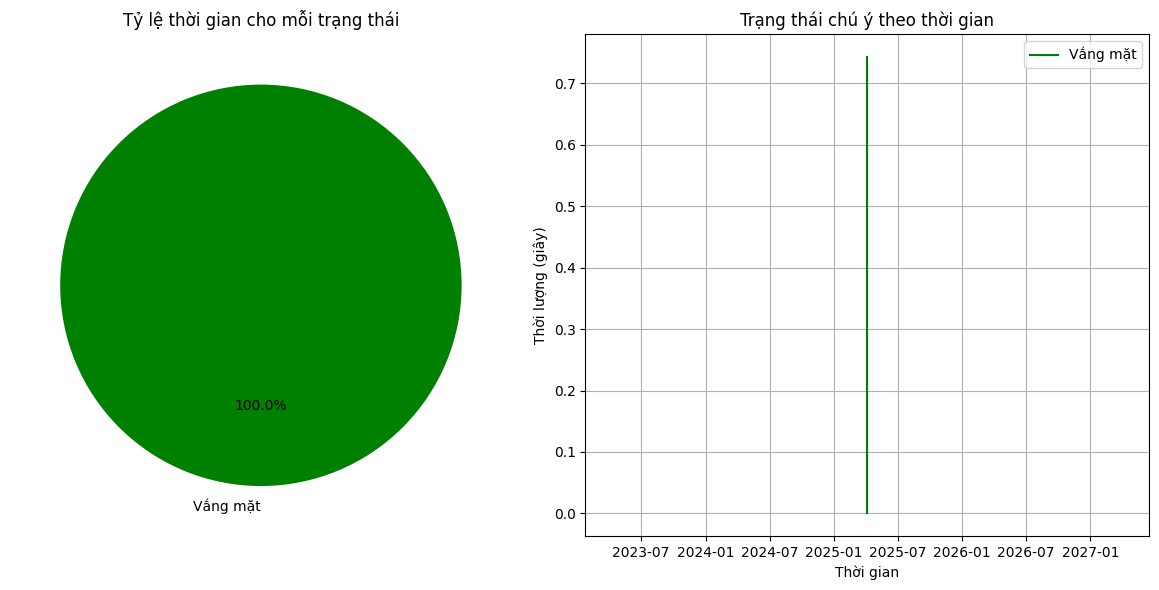

Đã lưu biểu đồ tóm tắt tại attention_summary.png
Đã lưu lịch sử trạng thái vào attention_history.csv
Đã lưu báo cáo vào attention_report.csv
Đã lưu báo cáo vào ./sample_data/attention_results/attention_report.json
Đã lưu kết quả theo dõi vào attention_results/attention_history.csv


In [46]:
run_attention_monitoring_demo()

In [42]:
import glob

def demo_with_existing_images(image_folder_path):
    """
    Hàm demo phân tích trạng thái chú ý với ảnh từ đường dẫn có sẵn
    
    Tham số:
        image_folder_path (str): Đường dẫn đến thư mục chứa ảnh cần phân tích
    """
    print(f"Bắt đầu demo hệ thống theo dõi sự chú ý với ảnh từ thư mục: {image_folder_path}")
    
    # Kiểm tra thư mục ảnh có tồn tại
    if not os.path.exists(image_folder_path):
        print(f"Lỗi: Không tìm thấy thư mục {image_folder_path}")
        return []
    
    # Khởi tạo hệ thống theo dõi sự chú ý
    attention_system = AttentionMonitoringSystem(
        face_detector_method='mtcnn',
        feature_extractor_method='resnet',
        classifier_model_path='attention_classifier.pkl',
        device=device
    )
    
    # Tạo thư mục để lưu kết quả
    output_dir = './sample_data/attention_results'
    os.makedirs(output_dir, exist_ok=True)
    
    # Tìm tất cả ảnh trong thư mục
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(image_folder_path, ext)))
        image_files.extend(glob.glob(os.path.join(image_folder_path, ext.upper())))
    
    if not image_files:
        print(f"Không tìm thấy ảnh trong thư mục {image_folder_path}")
        return []
    
    print(f"Tìm thấy {len(image_files)} ảnh để phân tích")
    
    # Xử lý từng ảnh
    results = []
    
    print("\nPhân tích các ảnh:")
    for idx, img_path in enumerate(image_files):
        img_name = os.path.basename(img_path)
        print(f"\n{idx+1}/{len(image_files)}. Đang phân tích ảnh: {img_name}")
        
        try:
            # Đọc ảnh
            img = cv2.imread(img_path)
            if img is None:
                print(f"   Không thể đọc ảnh: {img_path}")
                continue
            
            # Xử lý ảnh
            processed_img, state = attention_system.process_frame(img)
            
            # Lưu kết quả
            result = {
                'name': img_name,
                'path': img_path,
                'detected_state': state['state'],
                'confidence': state['confidence']
            }
            results.append(result)
            
            # Thông báo kết quả
            print(f"   Phát hiện: {state['state']} (Độ tin cậy: {state['confidence']:.2f})")
            
            # Lưu ảnh đã xử lý
            output_img_path = os.path.join(output_dir, f"processed_{img_name}")
            cv2.imwrite(output_img_path, processed_img)
            print(f"   Đã lưu ảnh đã xử lý tại: {output_img_path}")
            
            # Hiển thị ảnh
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title('Ảnh gốc')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Kết quả: {state["state"]} ({state["confidence"]:.2f})')
            plt.axis('off')
            
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}_comparison.jpg"))
            plt.show()
            
        except Exception as e:
            print(f"   Lỗi khi xử lý ảnh {img_name}: {e}")
            import traceback
            traceback.print_exc()
    
    if not results:
        print("Không có ảnh nào được phân tích thành công")
        return []
    
    # Tạo báo cáo tổng hợp
    print("\n=== BÁO CÁO TỔNG HỢP ===")
    print(f"Tổng số ảnh đã phân tích thành công: {len(results)}/{len(image_files)}")
    
    # Thống kê theo trạng thái
    state_counts = {}
    for r in results:
        state = r['detected_state']
        state_counts[state] = state_counts.get(state, 0) + 1
    
    print("\nPhân phối trạng thái phát hiện:")
    for state, count in state_counts.items():
        percentage = (count / len(results)) * 100
        print(f"  {state}: {count} ảnh ({percentage:.1f}%)")
    
    # Tạo báo cáo trực quan
    plt.figure(figsize=(15, 10))
    
    # Biểu đồ tròn cho phân phối trạng thái
    plt.subplot(2, 2, 1)
    labels = list(state_counts.keys())
    sizes = list(state_counts.values())
    colors = ['green', 'orange', 'red', 'gray'][:len(labels)]  # Màu sắc cho các trạng thái
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Phân phối trạng thái phát hiện')
    
    # Biểu đồ cột cho số lượng ảnh theo trạng thái
    plt.subplot(2, 2, 2)
    plt.bar(labels, sizes, color=colors)
    plt.title('Số lượng ảnh theo trạng thái')
    plt.ylabel('Số lượng ảnh')
    
    # Biểu đồ độ tin cậy cho từng ảnh
    plt.subplot(2, 1, 2)
    
    # Sắp xếp kết quả theo trạng thái và độ tin cậy
    sorted_results = sorted(results, key=lambda x: (x['detected_state'], -x['confidence']))
    names = [r['name'] for r in sorted_results]
    confidences = [r['confidence'] for r in sorted_results]
    states = [r['detected_state'] for r in sorted_results]
    
    # Tạo màu sắc dựa trên trạng thái
    state_to_color = {
        'Chú ý': 'green',
        'Mất tập trung': 'orange',
        'Buồn ngủ': 'red',
        'Vắng mặt': 'gray'
    }
    bar_colors = [state_to_color.get(state, 'blue') for state in states]
    
    # Vẽ biểu đồ cột
    if len(names) > 10:
        plt.figure(figsize=(max(15, len(names) * 0.5), 8))  # Điều chỉnh kích thước dựa trên số ảnh
    
    bars = plt.bar(range(len(names)), confidences, color=bar_colors)
    plt.title('Độ tin cậy cho từng ảnh')
    plt.xlabel('Ảnh')
    plt.ylabel('Độ tin cậy')
    plt.ylim(0, 1.0)
    
    # Đổi tên trục x thành tên file nếu số lượng ảnh ít
    if len(names) <= 10:
        plt.xticks(range(len(names)), names, rotation=45, ha='right')
    else:
        plt.xticks([])  # Ẩn nhãn nếu quá nhiều ảnh
        
    # Thêm nhãn thông tin trên mỗi cột
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f"{confidences[i]:.2f}", ha='center', va='bottom', rotation=0)
        
        # Thêm nhãn tên file nếu có nhiều ảnh
        if len(names) > 10:
            plt.text(bar.get_x() + bar.get_width()/2., 0.02,
                    names[i], ha='right', va='bottom', rotation=90, fontsize=8)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'analysis_summary.jpg'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Lưu kết quả vào file CSV
    results_df = pd.DataFrame(results)
    csv_path = os.path.join(output_dir, 'analysis_results.csv')
    results_df.to_csv(csv_path, index=False)
    print(f"\nĐã lưu kết quả phân tích vào: {csv_path}")
    
    # Lưu kết quả vào file JSON
    json_path = os.path.join(output_dir, 'analysis_results.json')
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    print(f"Đã lưu kết quả phân tích vào: {json_path}")
    
    return results


In [43]:

if __name__ == "__main__":
    image_folder = "./images"
    
    # Chạy demo
    results = demo_with_existing_images(image_folder)

Bắt đầu demo hệ thống theo dõi sự chú ý với ảnh từ thư mục: ./images
Khởi tạo FaceFeatureExtractor với phương pháp: resnet
Đã tìm thấy thư viện facenet-pytorch
Đã tìm thấy thư viện Pillow
Đang tải mô hình InceptionResnetV1 (pretrained='vggface2')...
Đã tải mô hình InceptionResnetV1 thành công
Khởi tạo AttentionClassifier với loại mô hình: random_forest
Đã tìm thấy scikit-learn phiên bản 1.6.1
Khởi tạo mô hình mới
Đã khởi tạo mô hình RandomForestClassifier
Tìm thấy 3 ảnh để phân tích

Phân tích các ảnh:

1/3. Đang phân tích ảnh: anh3.jpg
Trích xuất đặc trưng cho 1 khuôn mặt với phương pháp 'resnet'
Khuôn mặt #1: Đã trích xuất embedding có kích thước (512,)
Lỗi khi dự đoán: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
   Lỗi khi xử lý ảnh anh3.jpg: too many values to unpack (expected 2)

2/3. Đang phân tích ảnh: anh2.jpg


Traceback (most recent call last):
  File "/var/folders/2b/dq8xsj0x04vdnmmdjz5hb3br0000gn/T/ipykernel_26082/3629284306.py", line 58, in demo_with_existing_images
    processed_img, state = attention_system.process_frame(img)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/2b/dq8xsj0x04vdnmmdjz5hb3br0000gn/T/ipykernel_26082/2175635850.py", line 46, in process_frame
    state = self.classify_attention(features)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/2b/dq8xsj0x04vdnmmdjz5hb3br0000gn/T/ipykernel_26082/2175635850.py", line 69, in classify_attention
    label, proba = self.classifier.predict(features[0])
    ^^^^^^^^^^^^
ValueError: too many values to unpack (expected 2)


Trích xuất đặc trưng cho 1 khuôn mặt với phương pháp 'resnet'
Khuôn mặt #1: Đã trích xuất embedding có kích thước (512,)
Lỗi khi dự đoán: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
   Lỗi khi xử lý ảnh anh2.jpg: too many values to unpack (expected 2)

3/3. Đang phân tích ảnh: anh1.jpg


Traceback (most recent call last):
  File "/var/folders/2b/dq8xsj0x04vdnmmdjz5hb3br0000gn/T/ipykernel_26082/3629284306.py", line 58, in demo_with_existing_images
    processed_img, state = attention_system.process_frame(img)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/2b/dq8xsj0x04vdnmmdjz5hb3br0000gn/T/ipykernel_26082/2175635850.py", line 46, in process_frame
    state = self.classify_attention(features)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/2b/dq8xsj0x04vdnmmdjz5hb3br0000gn/T/ipykernel_26082/2175635850.py", line 69, in classify_attention
    label, proba = self.classifier.predict(features[0])
    ^^^^^^^^^^^^
ValueError: too many values to unpack (expected 2)


Trích xuất đặc trưng cho 1 khuôn mặt với phương pháp 'resnet'
Khuôn mặt #1: Đã trích xuất embedding có kích thước (512,)
Lỗi khi dự đoán: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
   Lỗi khi xử lý ảnh anh1.jpg: too many values to unpack (expected 2)
Không có ảnh nào được phân tích thành công


Traceback (most recent call last):
  File "/var/folders/2b/dq8xsj0x04vdnmmdjz5hb3br0000gn/T/ipykernel_26082/3629284306.py", line 58, in demo_with_existing_images
    processed_img, state = attention_system.process_frame(img)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/2b/dq8xsj0x04vdnmmdjz5hb3br0000gn/T/ipykernel_26082/2175635850.py", line 46, in process_frame
    state = self.classify_attention(features)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/2b/dq8xsj0x04vdnmmdjz5hb3br0000gn/T/ipykernel_26082/2175635850.py", line 69, in classify_attention
    label, proba = self.classifier.predict(features[0])
    ^^^^^^^^^^^^
ValueError: too many values to unpack (expected 2)


In [ ]:
# 7. Tạo Dashboard để hiển thị kết quả
def create_dashboard(history_data):
    """
    Tạo dashboard để hiển thị kết quả theo dõi

    Tham số:
        history_data (list): Dữ liệu lịch sử theo dõi
    """
    import dash
    from dash import dcc, html
    from dash.dependencies import Input, Output
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Tạo DataFrame từ dữ liệu lịch sử
    df = pd.DataFrame(history_data)

    # Tính toán thời gian cho mỗi trạng thái
    state_durations = df.groupby('state')['duration'].sum()
    state_percentages = (state_durations / state_durations.sum() * 100).round(2)

    # Khởi tạo ứng dụng Dash
    app = dash.Dash(__name__)

    app.layout = html.Div([
        html.H1("Hệ thống theo dõi sự chú ý của học sinh"),

        html.Div([
            html.Div([
                html.H3("Tỷ lệ thời gian theo trạng thái"),
                dcc.Graph(id='pie-chart')
            ], className='six columns'),

            html.Div([
                html.H3("Theo dõi trạng thái theo thời gian"),
                dcc.Graph(id='time-series')
            ], className='six columns')
        ], className='row'),

        html.Div([
            html.H3("Báo cáo chi tiết"),
            html.Table([
                html.Thead(
                    html.Tr([
                        html.Th("Trạng thái"),
                        html.Th("Tổng thời gian (giây)"),
                        html.Th("Tỷ lệ (%)"),
                        html.Th("Thời gian trung bình (giây)")
                    ])
                ),
                html.Tbody([
                    html.Tr([
                        html.Td(state),
                        html.Td(f"{duration:.2f}"),
                        html.Td(f"{state_percentages[state]:.2f}%"),
                        html.Td(f"{df[df['state'] == state]['duration'].mean():.2f}")
                    ]) for state, duration in state_durations.items()
                ])
            ])
        ]),

        dcc.Interval(
            id='interval-component',
            interval=5*1000,  # 5 giây
            n_intervals=0
        )
    ])

    @app.callback(
        [Output('pie-chart', 'figure'),
         Output('time-series', 'figure')],
        [Input('interval-component', 'n_intervals')]
    )
    def update_graphs(n):
        # Biểu đồ tròn
        pie_fig = px.pie(
            names=state_durations.index,
            values=state_durations.values,
            title="Tỷ lệ thời gian theo trạng thái"
        )

        # Biểu đồ thời gian
        time_fig = px.scatter(
            df,
            x="timestamp",
            y="state",
            color="state",
            size="confidence",
            hover_data=["duration"],
            title="Trạng thái theo thời gian"
        )

        return pie_fig, time_fig

    return app

In [ ]:
# 8. Hàm chính để thử nghiệm mô hình
def main():
    print("=== HỆ THỐNG THEO DÕI SỰ CHÚ Ý CỦA HỌC SINH ===")
    print("1. Chạy demo webcam theo dõi sự chú ý")
    print("2. Tạo và huấn luyện mô hình")
    print("3. Hiển thị dashboard")
    print("4. Thoát")

    choice = input("Chọn một tùy chọn (1-4): ")

    if choice == '1':
        run_webcam_demo()
    elif choice == '2':
        # Tạo dữ liệu và huấn luyện mô hình
        print("Đang tạo dữ liệu tổng hợp...")
        data_generator = SyntheticDataGenerator()
        X, y = data_generator.generate_synthetic_data(n_samples=5000)

        # Trực quan hóa dữ liệu
        data_generator.visualize_data(X, y)

        print("Đang huấn luyện mô hình...")
        classifier = AttentionClassifier(model_type='random_forest')
        accuracy = classifier.train(X, y)

        # Lưu mô hình
        classifier.save_model('attention_classifier.pkl')
        print(f"Đã lưu mô hình với độ chính xác: {accuracy:.4f}")
    elif choice == '3':
        # Tải dữ liệu lịch sử nếu có
        try:
            history_df = pd.read_csv('attention_results/attention_history.csv')
            history_data = history_df.to_dict('records')

            # Khởi tạo dashboard
            app = create_dashboard(history_data)
            app.run_server(debug=True)
        except:
            print("Không tìm thấy dữ liệu lịch sử. Vui lòng chạy demo trước.")
    elif choice == '4':
        print("Thoát chương trình.")
    else:
        print("Lựa chọn không hợp lệ.")

In [68]:
# Chạy hệ thống
if __name__ == "__main__":
    main()


=== HỆ THỐNG THEO DÕI SỰ CHÚ Ý CỦA HỌC SINH ===
1. Chạy demo webcam theo dõi sự chú ý
2. Tạo và huấn luyện mô hình
3. Hiển thị dashboard
4. Thoát
Chọn một tùy chọn (1-4): 3
Không tìm thấy dữ liệu lịch sử. Vui lòng chạy demo trước.


In [31]:
# Demo mô phỏng dữ liệu theo dõi theo thời gian
def demo_time_series_simulation():
    """
    Mô phỏng dữ liệu theo dõi sự chú ý theo thời gian và trực quan hóa
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from datetime import datetime, timedelta

    print("Mô phỏng theo dõi sự chú ý của học sinh trong một buổi học (45 phút)")

    # Tạo dữ liệu mô phỏng
    np.random.seed(42)  # Đảm bảo kết quả có thể tái tạo

    # Thời gian mô phỏng (45 phút, mỗi bước 1 giây)
    n_steps = 45 * 60

    # Ma trận chuyển đổi trạng thái (các trạng thái có xu hướng duy trì)
    # 0: Chú ý, 1: Mất tập trung, 2: Buồn ngủ, 3: Vắng mặt
    transition_matrix = np.array([
        [0.985, 0.01, 0.004, 0.001],  # Từ Chú ý
        [0.02, 0.97, 0.008, 0.002],   # Từ Mất tập trung
        [0.01, 0.03, 0.955, 0.005],   # Từ Buồn ngủ
        [0.03, 0.02, 0.01, 0.94]      # Từ Vắng mặt
    ])

    # Điều chỉnh ma trận chuyển đổi theo thời gian
    # Đầu tiết học: Tập trung cao
    early_matrix = transition_matrix.copy()

    # Giữa tiết học: Dễ mất tập trung hơn
    mid_matrix = transition_matrix.copy()
    mid_matrix[0, 1] = 0.03  # Từ chú ý -> mất tập trung
    mid_matrix[0, 0] = 0.965  # Điều chỉnh lại để tổng = 1

    # Cuối tiết học: Dễ buồn ngủ hơn
    late_matrix = transition_matrix.copy()
    late_matrix[0, 2] = 0.02  # Từ chú ý -> buồn ngủ
    late_matrix[1, 2] = 0.02  # Từ mất tập trung -> buồn ngủ
    late_matrix[0, 0] = 0.969  # Điều chỉnh lại
    late_matrix[1, 1] = 0.958  # Điều chỉnh lại

    # Trạng thái ban đầu (bắt đầu với Chú ý)
    current_state = 0

    # Khởi tạo chuỗi trạng thái
    states = []

    # Mô phỏng chuỗi thời gian
    for i in range(n_steps):
        # Thêm trạng thái hiện tại
        states.append(current_state)

        # Chọn ma trận chuyển đổi thích hợp dựa trên thời gian
        if i < 15*60:  # 15 phút đầu
            tm = early_matrix
        elif i < 30*60:  # 15-30 phút
            tm = mid_matrix
        else:  # 30-45 phút
            tm = late_matrix

        # Quyết định trạng thái tiếp theo
        current_state = np.random.choice(4, p=tm[current_state])

    # Tạo DataFrame
    start_time = datetime.now().replace(hour=8, minute=0, second=0, microsecond=0)  # 8:00 AM
    timestamps = [start_time + timedelta(seconds=i) for i in range(n_steps)]
    state_names = ['Chú ý', 'Mất tập trung', 'Buồn ngủ', 'Vắng mặt']

    df = pd.DataFrame({
        'timestamp': timestamps,
        'state_id': states,
        'state': [state_names[s] for s in states],
        'confidence': np.random.uniform(0.75, 1.0, n_steps)  # Mô phỏng độ tin cậy
    })

    # Tính toán thời lượng cho mỗi đoạn trạng thái liên tục
    df['segment'] = (df['state_id'] != df['state_id'].shift()).cumsum()

    # Thống kê
    state_counts = df['state'].value_counts()
    state_percentages = (state_counts / len(df) * 100).round(2)

    # Tính thời gian trung bình cho mỗi đoạn trạng thái liên tục
    segment_durations = df.groupby(['segment', 'state']).size()
    avg_segment_durations = segment_durations.groupby(level=1).mean().round(2)

    # Hiển thị thống kê
    print("\n===== THỐNG KÊ MÔ PHỎNG =====")
    print(f"Tổng thời gian mô phỏng: 45 phút ({n_steps} giây)")

    print("\nTỷ lệ thời gian cho mỗi trạng thái:")
    for state, percentage in state_percentages.items():
        print(f"  - {state}: {percentage:.2f}%")

    print("\nThời gian trung bình cho mỗi đoạn trạng thái liên tục (giây):")
    for state, duration in avg_segment_durations.items():
        minutes = int(duration // 60)
        seconds = int(duration % 60)
        print(f"  - {state}: {minutes}m {seconds}s")

    # Trực quan hóa
    plt.figure(figsize=(15, 10))

    # 1. Biểu đồ tỷ lệ thời gian
    plt.subplot(2, 2, 1)
    colors = ['green', 'orange', 'red', 'gray']
    plt.pie(state_percentages, labels=state_percentages.index, colors=colors,
            autopct='%1.1f%%', startangle=90)
    plt.title('Tỷ lệ thời gian cho mỗi trạng thái')

    # 2. Biểu đồ thời gian
    plt.subplot(2, 1, 2)

    # Chuyển đổi trạng thái thành giá trị số để vẽ
    state_map = {state: i for i, state in enumerate(state_names)}
    df['state_value'] = df['state'].map(state_map)

    # Chia thành các khoảng 5 phút
    time_chunks = [i*300 for i in range(n_steps//300 + 1)]
    chunk_labels = [f'{i*5}m' for i in range(n_steps//300 + 1)]

    # Vẽ biểu đồ trạng thái theo thời gian
    for state_id, state_name in enumerate(state_names):
        state_df = df[df['state_id'] == state_id]
        plt.scatter(state_df.index, [state_id] * len(state_df),
                   label=state_name, color=colors[state_id], s=10, alpha=0.7)

    plt.yticks(range(len(state_names)), state_names)
    plt.xticks(time_chunks, chunk_labels)
    plt.xlabel('Thời gian (phút)')
    plt.ylabel('Trạng thái')
    plt.title('Trạng thái chú ý theo thời gian')
    plt.grid(True, alpha=0.3)

    # 3. Biểu đồ chuyển đổi trạng thái
    plt.subplot(2, 2, 2)

    # Tính ma trận chuyển đổi từ dữ liệu
    transition_counts = np.zeros((4, 4))

    for i in range(1, len(df)):
        prev_state = df.iloc[i-1]['state_id']
        curr_state = df.iloc[i]['state_id']
        transition_counts[prev_state, curr_state] += 1

    # Chuẩn hóa để có xác suất
    row_sums = transition_counts.sum(axis=1, keepdims=True)
    transition_probs = np.divide(transition_counts, row_sums,
                                out=np.zeros_like(transition_counts), where=row_sums!=0)

    # Vẽ heatmap
    sns.heatmap(transition_probs, annot=True, fmt='.3f', cmap='Blues',
               xticklabels=state_names, yticklabels=state_names)
    plt.title('Ma trận chuyển đổi trạng thái')
    plt.xlabel('Trạng thái tiếp theo')
    plt.ylabel('Trạng thái hiện tại')

    plt.tight_layout()
    plt.show()

    # Biểu đồ đường xu hướng
    plt.figure(figsize=(15, 6))

    # Tính tỷ lệ trạng thái theo thời gian (mỗi phút)
    minute_stats = []

    for minute in range(45):
        start_idx = minute * 60
        end_idx = (minute + 1) * 60
        minute_df = df.iloc[start_idx:end_idx]

        minute_stats.append({
            'minute': minute,
            'attention': (minute_df['state'] == 'Chú ý').mean() * 100,
            'distracted': (minute_df['state'] == 'Mất tập trung').mean() * 100,
            'sleepy': (minute_df['state'] == 'Buồn ngủ').mean() * 100,
            'absent': (minute_df['state'] == 'Vắng mặt').mean() * 100
        })

    minute_df = pd.DataFrame(minute_stats)

    plt.plot(minute_df['minute'], minute_df['attention'], 'g-', label='Chú ý', linewidth=2)
    plt.plot(minute_df['minute'], minute_df['distracted'], 'orange', label='Mất tập trung', linewidth=2)
    plt.plot(minute_df['minute'], minute_df['sleepy'], 'r-', label='Buồn ngủ', linewidth=2)
    plt.plot(minute_df['minute'], minute_df['absent'], 'gray', label='Vắng mặt', linewidth=2)

    plt.xlabel('Thời gian (phút)')
    plt.ylabel('Tỷ lệ (%)')
    plt.title('Xu hướng trạng thái chú ý theo thời gian')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Đánh dấu các giai đoạn
    plt.axvline(x=15, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=30, color='black', linestyle='--', alpha=0.5)
    plt.text(7, 5, 'Giai đoạn 1: Đầu giờ học', ha='center')
    plt.text(22, 5, 'Giai đoạn 2: Giữa giờ học', ha='center')
    plt.text(37, 5, 'Giai đoạn 3: Cuối giờ học', ha='center')

    plt.tight_layout()
    plt.show()

    return df


Mô phỏng theo dõi sự chú ý của học sinh trong một buổi học (45 phút)

===== THỐNG KÊ MÔ PHỎNG =====
Tổng thời gian mô phỏng: 45 phút (2700 giây)

Tỷ lệ thời gian cho mỗi trạng thái:
  - Chú ý: 41.63%
  - Mất tập trung: 35.19%
  - Buồn ngủ: 21.59%
  - Vắng mặt: 1.59%

Thời gian trung bình cho mỗi đoạn trạng thái liên tục (giây):
  - Buồn ngủ: 0m 26s
  - Chú ý: 0m 44s
  - Mất tập trung: 0m 30s
  - Vắng mặt: 0m 14s


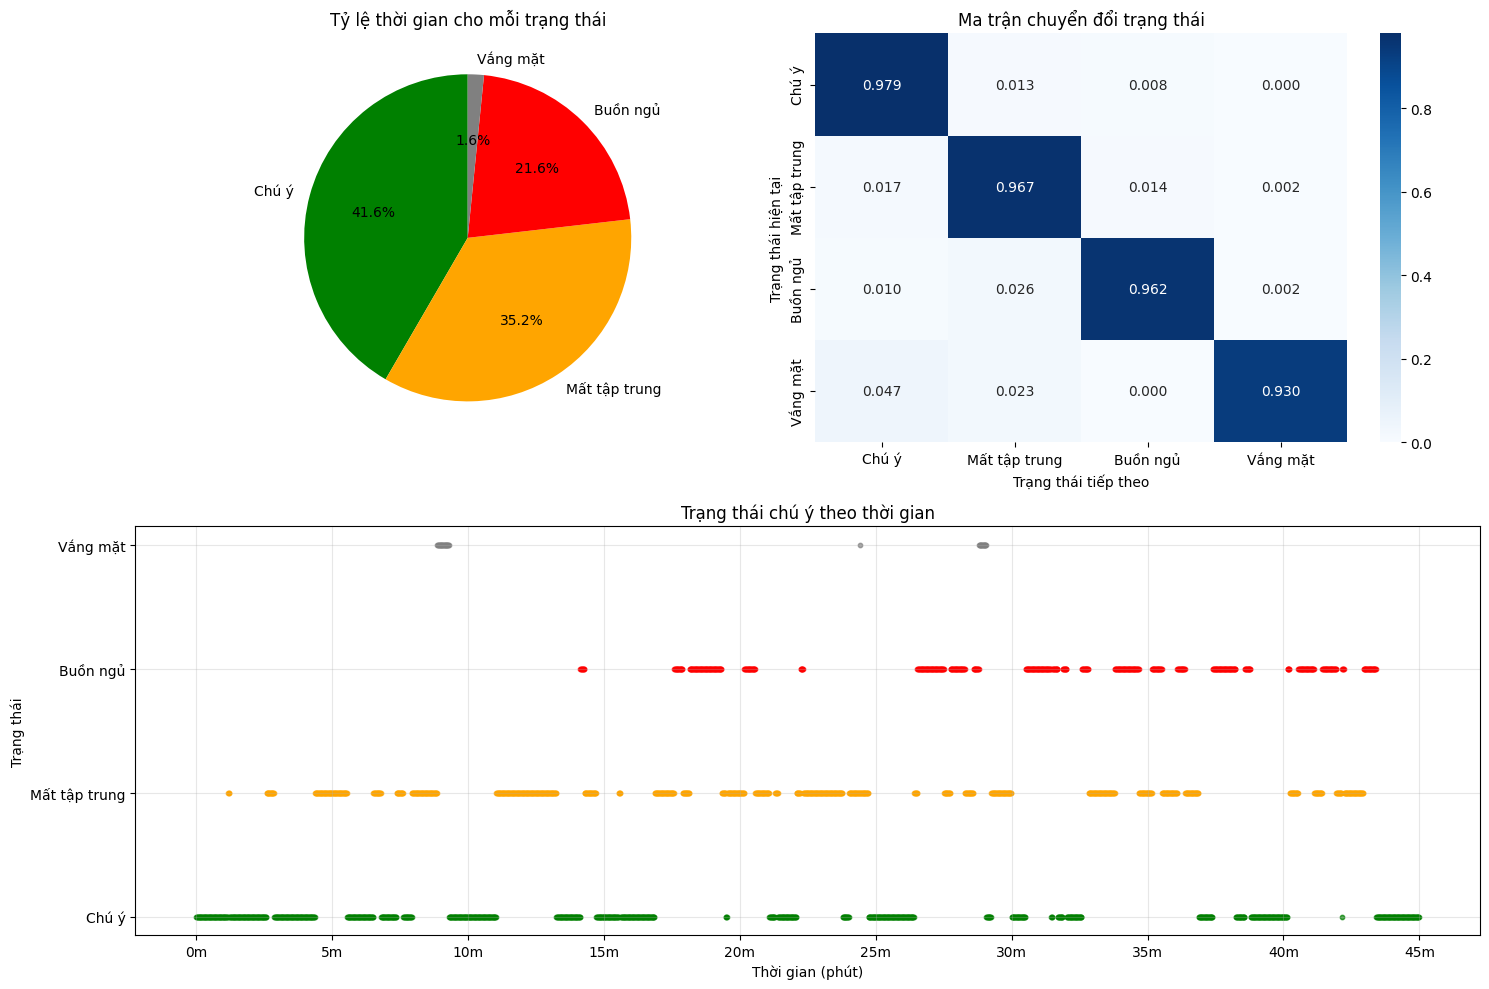

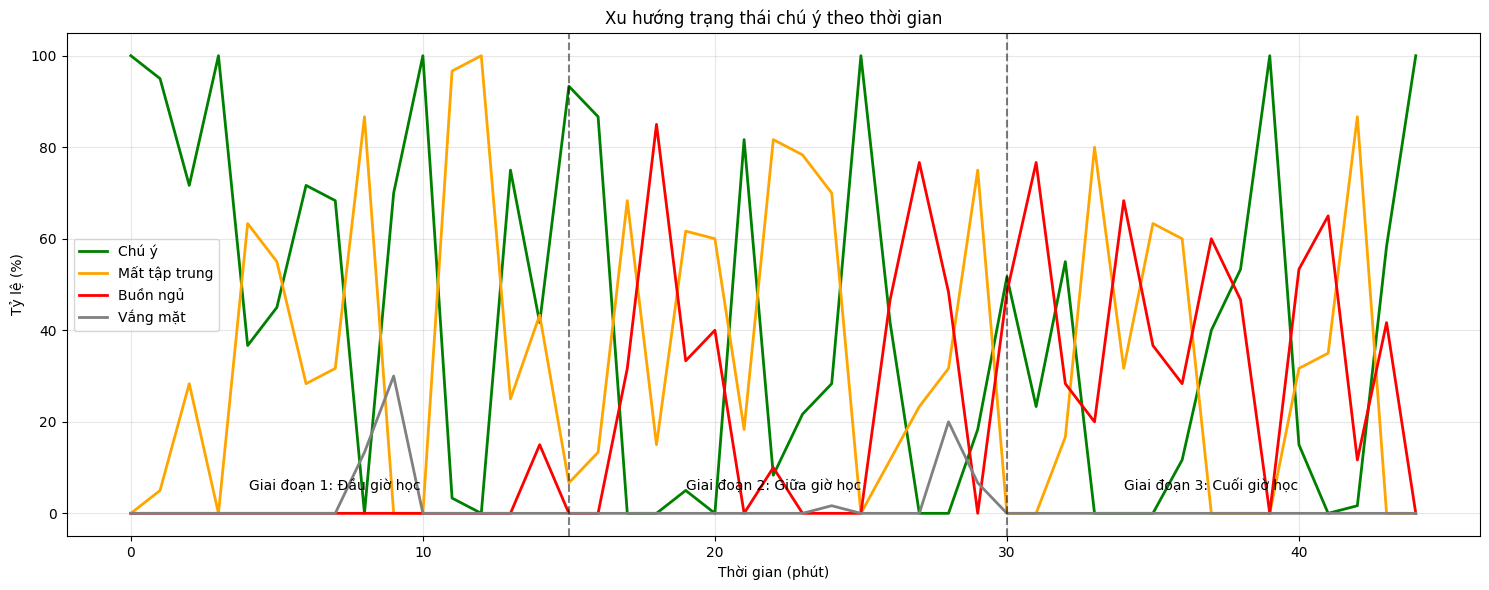

timestamp  state_id  state  confidence  segment  state_value
0    2025-04-05 08:00:00         0  Chú ý    0.880324        1            0
1    2025-04-05 08:00:01         0  Chú ý    0.994003        1            0
2    2025-04-05 08:00:02         0  Chú ý    0.781388        1            0
3    2025-04-05 08:00:03         0  Chú ý    0.754237        1            0
4    2025-04-05 08:00:04         0  Chú ý    0.942540        1            0
...                  ...       ...    ...         ...      ...          ...
2695 2025-04-05 08:44:55         0  Chú ý    0.843011       81            0
2696 2025-04-05 08:44:56         0  Chú ý    0.773112       81            0
2697 2025-04-05 08:44:57         0  Chú ý    0.864475       81            0
2698 2025-04-05 08:44:58         0  Chú ý    0.848620       81            0
2699 2025-04-05 08:44:59         0  Chú ý    0.966765       81            0

[2700 rows x 6 columns]

In [32]:
demo_time_series_simulation()

Độ chính xác: 0.9683
Báo cáo phân loại:
               precision    recall  f1-score   support

        Chú ý       0.92      1.00      0.96       217
Mất tập trung       0.99      0.91      0.95       197
     Buồn ngủ       1.00      0.99      1.00       186

     accuracy                           0.97       600
    macro avg       0.97      0.97      0.97       600
 weighted avg       0.97      0.97      0.97       600



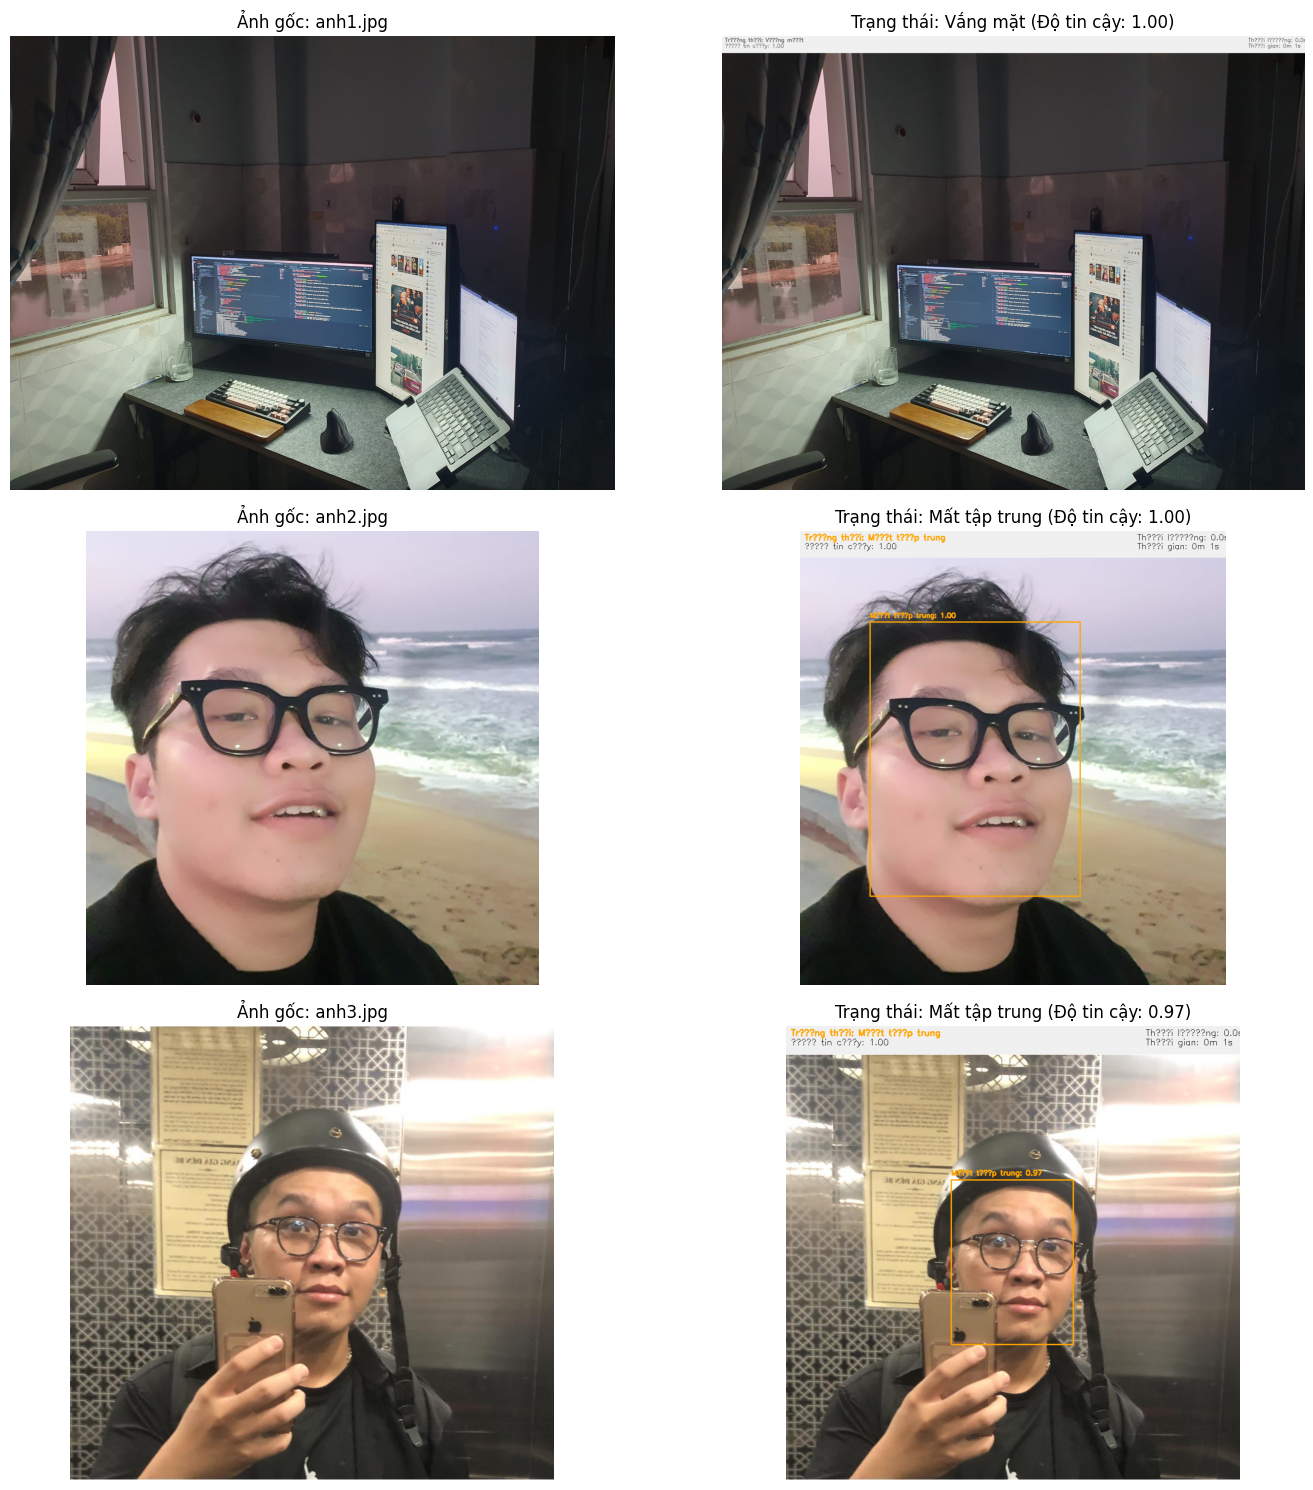


Kết quả phân loại:
      image          state  confidence
0  anh1.jpg       Vắng mặt    1.000000
1  anh2.jpg  Mất tập trung    1.000000
2  anh3.jpg  Mất tập trung    0.966836


In [51]:
# Ví dụ cách sử dụng
# 1. Demo với ảnh mẫu
results = demo_with_sample_images()


Mô phỏng theo dõi sự chú ý của học sinh trong một buổi học (45 phút)

===== THỐNG KÊ MÔ PHỎNG =====
Tổng thời gian mô phỏng: 45 phút (2700 giây)

Tỷ lệ thời gian cho mỗi trạng thái:
  - Chú ý: 41.63%
  - Mất tập trung: 35.19%
  - Buồn ngủ: 21.59%
  - Vắng mặt: 1.59%

Thời gian trung bình cho mỗi đoạn trạng thái liên tục (giây):
  - Buồn ngủ: 0m 26s
  - Chú ý: 0m 44s
  - Mất tập trung: 0m 30s
  - Vắng mặt: 0m 14s


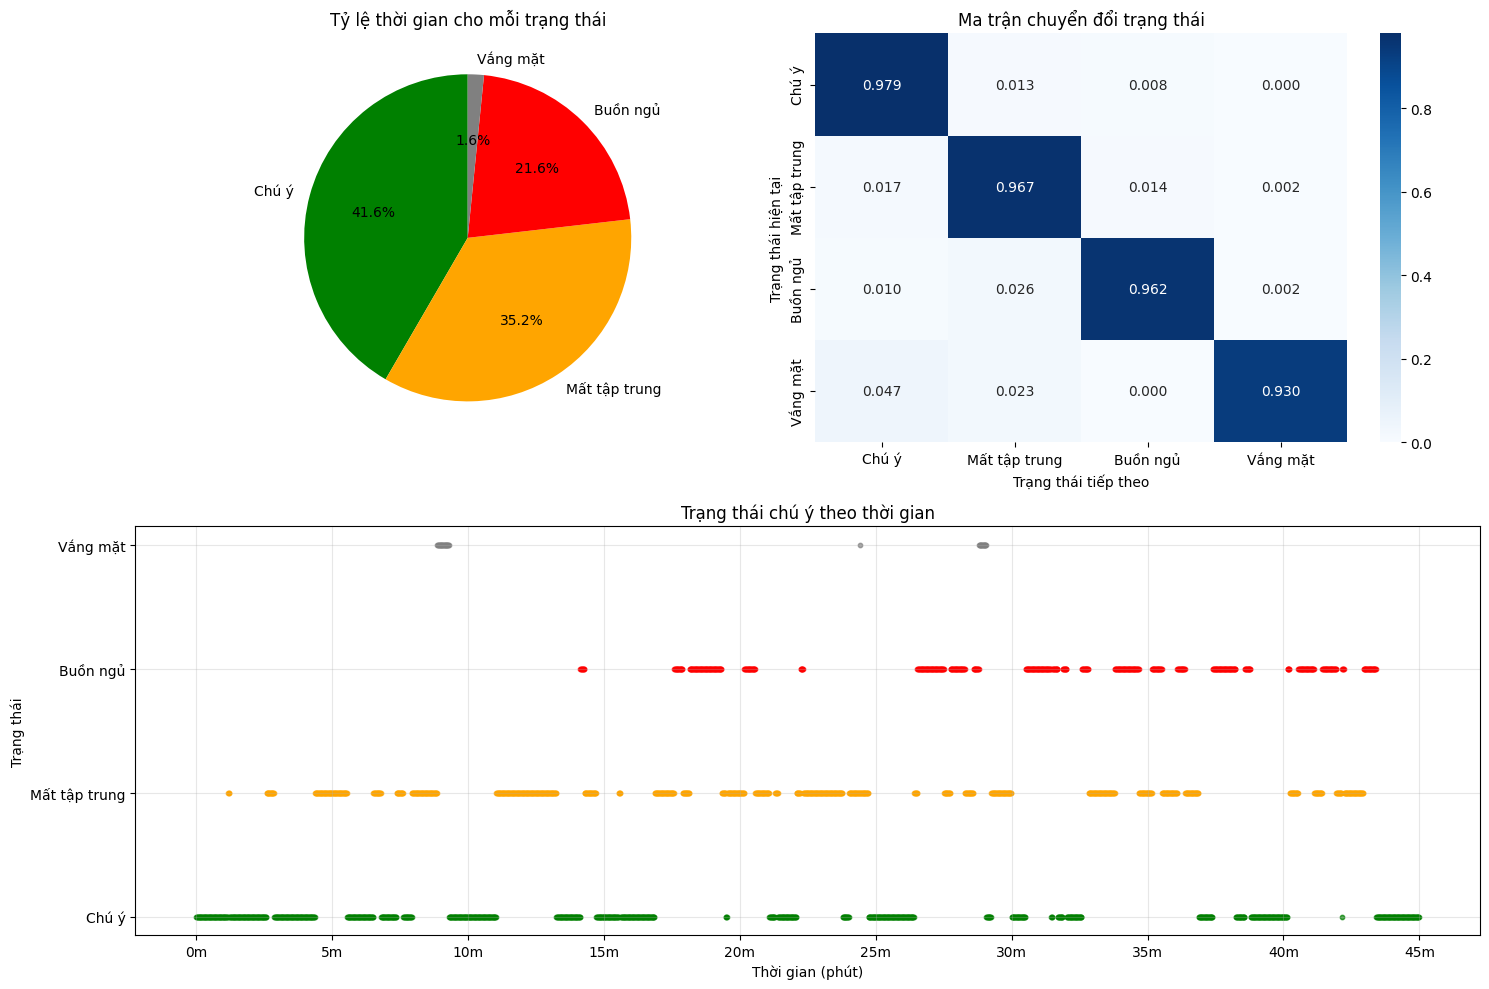

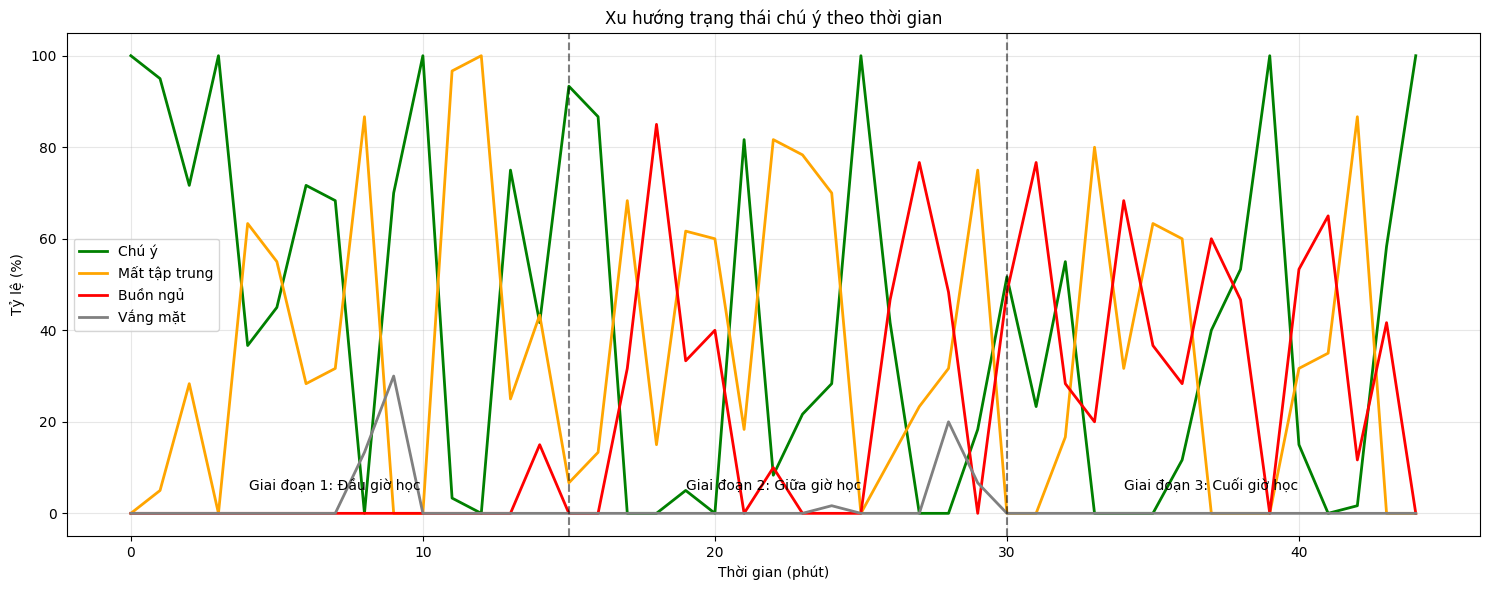

In [52]:
# 2. Mô phỏng dữ liệu theo thời gian
time_series_data = demo_time_series_simulation()



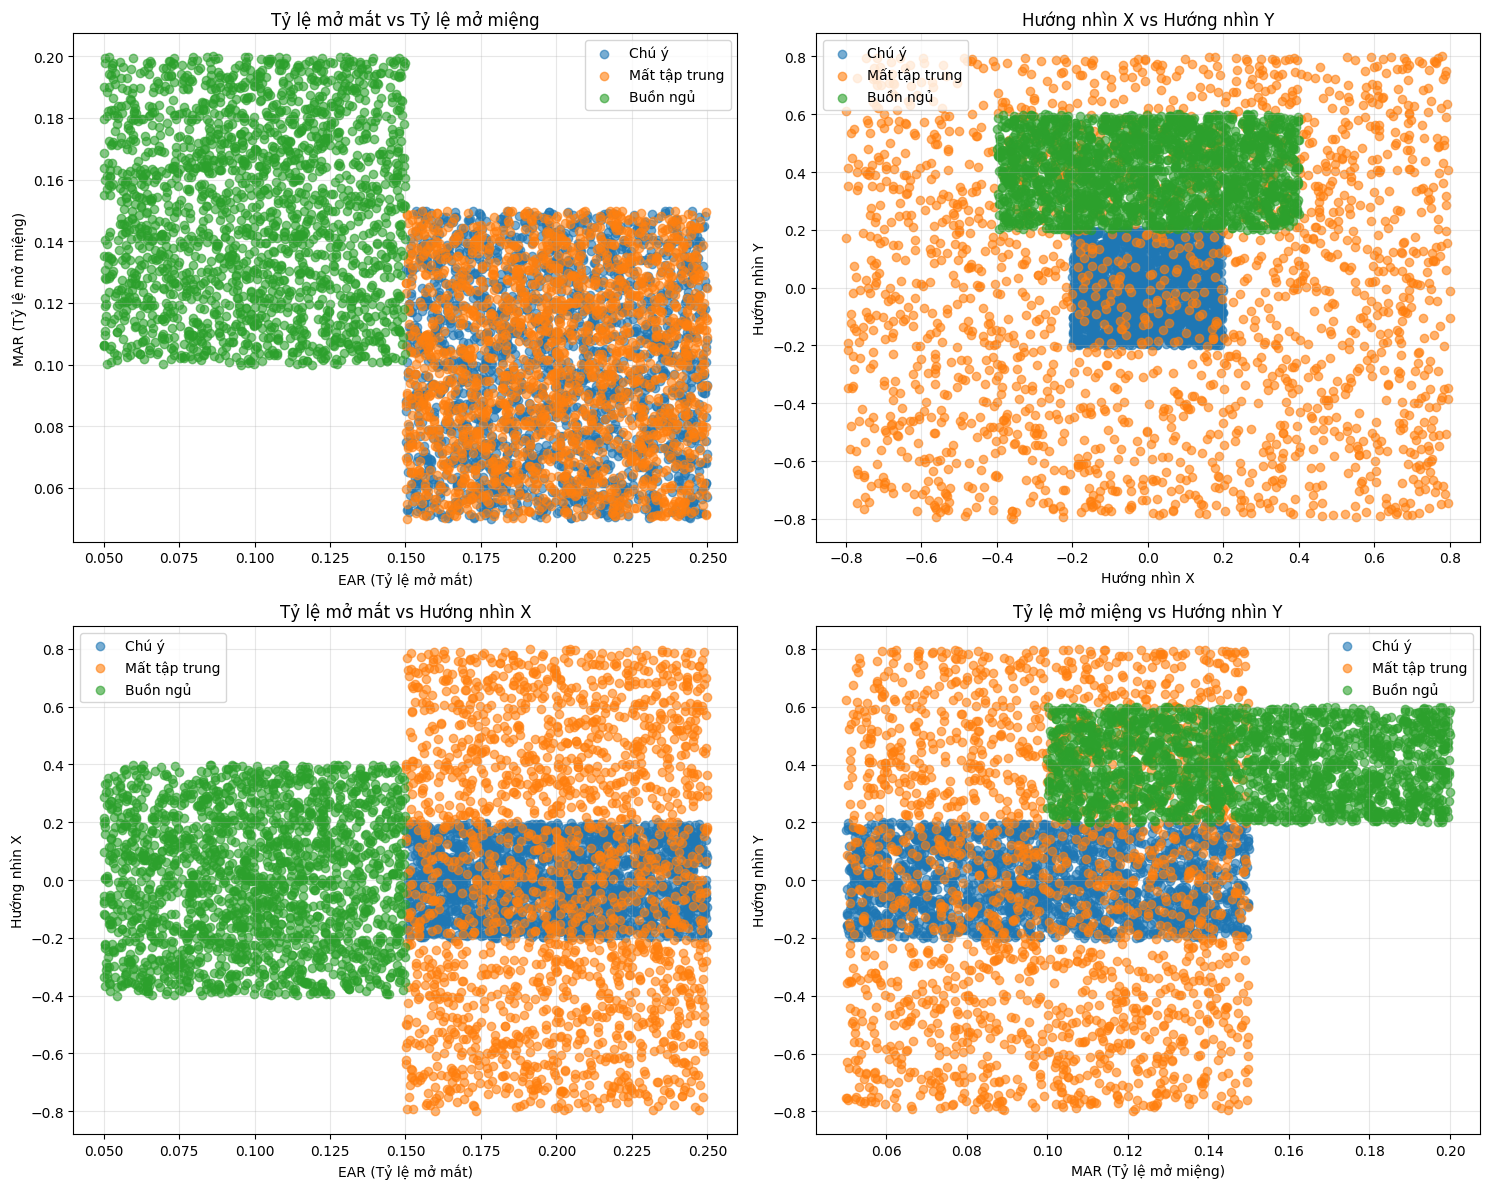

Độ chính xác: 0.9750
Báo cáo phân loại:
               precision    recall  f1-score   support

        Chú ý       0.94      1.00      0.97       437
Mất tập trung       1.00      0.92      0.96       380
     Buồn ngủ       1.00      1.00      1.00       383

     accuracy                           0.97      1200
    macro avg       0.98      0.97      0.98      1200
 weighted avg       0.98      0.97      0.97      1200



0.975

In [53]:
# 3. Huấn luyện mô hình với dữ liệu tổng hợp
data_generator = SyntheticDataGenerator()
X, y = data_generator.generate_synthetic_data(6000)
data_generator.visualize_data(X, y)
classifier = AttentionClassifier()
classifier.train(X, y)# Demo và Mô hình hóa

In [56]:
def demo_face_detection():
    """
    Demo phát hiện khuôn mặt bằng MTCNN và YOLOv8-Face
    """
    try:
        image_path = '/Users/lehoangan/Workspaces/face-detection-tracking/images/anh1.jpg'

        if not os.path.exists(image_path):
            raise Exception("Không thể tải ảnh mẫu")
    except:
        # Nếu không tải được, yêu cầu người dùng upload ảnh
        print("Hãy upload một ảnh có chứa khuôn mặt:")

    # Đọc ảnh
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 1. Phát hiện khuôn mặt bằng MTCNN
    print("Đang phát hiện khuôn mặt bằng MTCNN...")
    mtcnn_detector = FaceDetector(method='mtcnn')
    boxes, probs = mtcnn_detector.detect_faces(image)

    # Vẽ kết quả MTCNN
    mtcnn_result = image.copy()
    if len(boxes) > 0:
        for box, prob in zip(boxes, probs):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(mtcnn_result, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(mtcnn_result, f"Conf: {prob:.2f}", (x1, y1 - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # 2. Phát hiện khuôn mặt bằng YOLOv8-Face
    print("Đang phát hiện khuôn mặt bằng YOLOv8-Face...")
    try:
        # Tải mô hình YOLOv8-Face
        !wget -q https://github.com/derronqi/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt

        yolo_detector = FaceDetector(method='yolov8')
        yolo_boxes, yolo_probs = yolo_detector.detect_faces(image)

        # Vẽ kết quả YOLOv8
        yolo_result = image.copy()

        if len(yolo_boxes) > 0:
            for box, prob in zip(yolo_boxes, yolo_probs):
                x1, y1, x2, y2 = box.astype(int)
                cv2.rectangle(yolo_result, (x1, y1), (x2, y2), (0, 165, 255), 2)
                cv2.putText(yolo_result, f"Conf: {prob:.2f}", (x1, y1 - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 165, 255), 2)
    except:
        print("Không thể tải mô hình YOLOv8-Face, sử dụng MediaPipe thay thế")
        # Sử dụng MediaPipe làm thay thế
        mp_face_detection = mp.solutions.face_detection
        with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detector:
            results = face_detector.process(image_rgb)

            yolo_result = image.copy()

            if results.detections:
                for detection in results.detections:
                    bbox = detection.location_data.relative_bounding_box
                    h, w, _ = image.shape
                    x1 = int(bbox.xmin * w)
                    y1 = int(bbox.ymin * h)
                    x2 = int((bbox.xmin + bbox.width) * w)
                    y2 = int((bbox.ymin + bbox.height) * h)

                    cv2.rectangle(yolo_result, (x1, y1), (x2, y2), (0, 165, 255), 2)
                    cv2.putText(yolo_result, f"Conf: {detection.score[0]:.2f}", (x1, y1 - 10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 165, 255), 2)

    # Hiển thị kết quả
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 3, 1)
    plt.title('Ảnh gốc')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f'MTCNN ({len(boxes)} khuôn mặt)')
    plt.imshow(cv2.cvtColor(mtcnn_result, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('YOLOv8-Face / MediaPipe')
    plt.imshow(cv2.cvtColor(yolo_result, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"MTCNN phát hiện được {len(boxes)} khuôn mặt")
    return mtcnn_result, yolo_result

Đang phát hiện khuôn mặt bằng MTCNN...
Đang phát hiện khuôn mặt bằng YOLOv8-Face...
--2025-03-28 16:03:44--  https://github.com/derronqi/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-03-28 16:03:44 ERROR 404: Not Found.

Không thể tải mô hình YOLOv8-Face, sử dụng MediaPipe thay thế


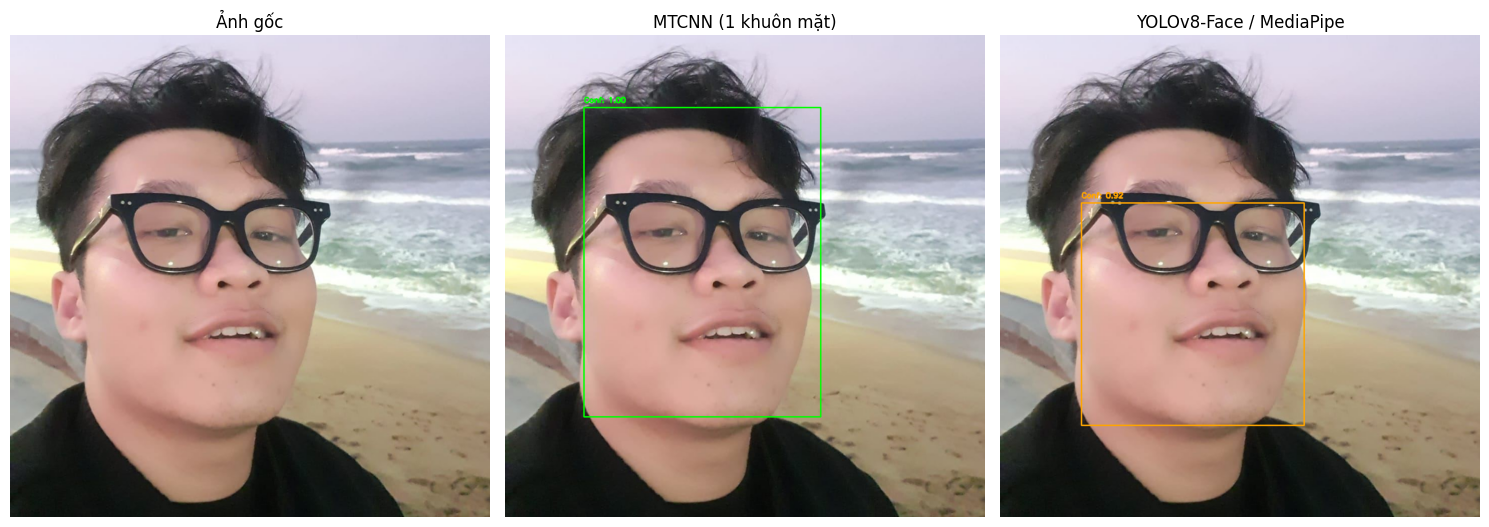

MTCNN phát hiện được 1 khuôn mặt


(array([[[245, 228, 231],
         [245, 228, 231],
         [245, 228, 231],
         ...,
         [226, 205, 208],
         [226, 205, 208],
         [226, 205, 208]],
 
        [[245, 228, 231],
         [245, 228, 231],
         [245, 228, 231],
         ...,
         [226, 205, 208],
         [226, 205, 208],
         [226, 205, 208]],
 
        [[245, 228, 231],
         [245, 228, 231],
         [245, 228, 231],
         ...,
         [226, 205, 208],
         [226, 205, 208],
         [226, 205, 208]],
 
        ...,
 
        [[ 26,  30,  24],
         [ 26,  30,  24],
         [ 25,  29,  23],
         ...,
         [ 65,  95, 112],
         [ 64,  94, 111],
         [ 65,  95, 114]],
 
        [[ 26,  30,  24],
         [ 26,  30,  24],
         [ 25,  29,  23],
         ...,
         [ 62,  90, 107],
         [ 61,  89, 106],
         [ 62,  89, 109]],
 
        [[ 26,  30,  24],
         [ 26,  30,  24],
         [ 25,  29,  23],
         ...,
         [ 59,  87, 104],
  

In [64]:
demo_face_detection()

In [57]:
# Demo trích xuất đặc trưng khuôn mặt
def demo_face_features():
    """
    Demo trích xuất đặc trưng khuôn mặt và phân tích
    """

    # Tải ảnh mẫu hoặc sử dụng ảnh upload
    try:
        image_path = '/content/sample_images/anh2.jpg'

        if not os.path.exists(image_path):
            raise Exception("Không thể tải ảnh mẫu")
    except:
        # Nếu không tải được, yêu cầu người dùng upload ảnh
        print("Hãy upload một ảnh khuôn mặt rõ ràng:")
        upload = files.upload()
        image_path = next(iter(upload))

    # Đọc ảnh
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 1. Phát hiện khuôn mặt
    face_detector = FaceDetector(method='mtcnn')
    boxes, _ = face_detector.detect_faces(image)

    if len(boxes) == 0:
        print("Không phát hiện được khuôn mặt trong ảnh!")
        return None

    # Lấy khuôn mặt đầu tiên
    x1, y1, x2, y2 = boxes[0].astype(int)
    face_image = image[y1:y2, x1:x2]

    # 2. Trích xuất đặc trưng MediaPipe
    mp_face_mesh = mp.solutions.face_mesh
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        # Chuyển sang RGB
        face_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

        # Phát hiện landmarks
        results = face_mesh.process(face_rgb)

        # Vẽ landmarks lên ảnh
        annotated_face = face_rgb.copy()

        if results.multi_face_landmarks:
            # Vẽ lưới và đường viền khuôn mặt
            for face_landmarks in results.multi_face_landmarks:
                # Vẽ lưới khuôn mặt
                mp_drawing.draw_landmarks(
                    image=annotated_face,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())

                # Vẽ đường viền khuôn mặt, mắt, mũi, miệng
                mp_drawing.draw_landmarks(
                    image=annotated_face,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())

                # Trích xuất các điểm chính
                landmarks = []
                for landmark in face_landmarks.landmark:
                    h, w, _ = face_rgb.shape
                    x = int(landmark.x * w)
                    y = int(landmark.y * h)
                    landmarks.append((x, y))

                # Vẽ điểm mắt
                left_eye = landmarks[33]  # Điểm giữa mắt trái
                right_eye = landmarks[263]  # Điểm giữa mắt phải
                cv2.circle(annotated_face, left_eye, 3, (255, 0, 0), -1)
                cv2.circle(annotated_face, right_eye, 3, (255, 0, 0), -1)

                # Vẽ điểm miệng
                top_lip = landmarks[13]  # Điểm trên miệng
                bottom_lip = landmarks[14]  # Điểm dưới miệng
                cv2.circle(annotated_face, top_lip, 3, (0, 0, 255), -1)
                cv2.circle(annotated_face, bottom_lip, 3, (0, 0, 255), -1)

                # Vẽ điểm mũi
                nose_tip = landmarks[4]
                cv2.circle(annotated_face, nose_tip, 3, (0, 255, 0), -1)

                # Tính tỷ lệ mở mắt (Eye Aspect Ratio - EAR)
                left_eye_top = landmarks[159]
                left_eye_bottom = landmarks[145]
                right_eye_top = landmarks[386]
                right_eye_bottom = landmarks[374]

                # Vẽ tỷ lệ mở mắt
                cv2.line(annotated_face, left_eye_top, left_eye_bottom, (255, 255, 0), 1)
                cv2.line(annotated_face, right_eye_top, right_eye_bottom, (255, 255, 0), 1)

                # Tính tỷ lệ mở miệng (Mouth Aspect Ratio - MAR)
                cv2.line(annotated_face, top_lip, bottom_lip, (255, 0, 255), 1)

                # Tính hướng nhìn
                eye_center = ((left_eye[0] + right_eye[0]) // 2,
                             (left_eye[1] + right_eye[1]) // 2)
                cv2.line(annotated_face, eye_center, nose_tip, (0, 255, 255), 1)

        # Hiển thị kết quả
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title('Khuôn mặt gốc')
        plt.imshow(face_rgb)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Đặc trưng khuôn mặt')
        plt.imshow(annotated_face)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Trích xuất và hiển thị các đặc trưng chính
        if results.multi_face_landmarks:
            import pandas as pd

            # Tạo extractor
            feature_extractor = FaceFeatureExtractor(method='mediapipe')

            # Trích xuất đặc trưng
            features = feature_extractor.extract_features(image, boxes)

            if features and features[0] is not None:
                feature_names = ['EAR (Mắt)', 'MAR (Miệng)', 'Gaze X', 'Gaze Y']
                feature_values = features[0]

                # Hiển thị giá trị đặc trưng
                feature_df = pd.DataFrame({
                    'Đặc trưng': feature_names,
                    'Giá trị': feature_values
                })

                print("Các đặc trưng được trích xuất:")
                print(feature_df)

                # Hiển thị dưới dạng biểu đồ
                plt.figure(figsize=(10, 6))
                plt.bar(feature_names, feature_values)
                plt.title('Các đặc trưng được trích xuất')
                plt.ylabel('Giá trị')
                plt.grid(True, alpha=0.3)
                plt.show()

                # Phân loại trạng thái chú ý
                # Tạo dữ liệu tổng hợp để huấn luyện mô hình
                data_generator = SyntheticDataGenerator()
                X, y = data_generator.generate_synthetic_data(n_samples=3000)

                # Huấn luyện mô hình
                classifier = AttentionClassifier(model_type='random_forest')
                classifier.train(X, y)

                # Dự đoán trạng thái
                label, confidence = classifier.predict(feature_values)
                state_name = classifier.classes[label]

                print(f"\nPhân loại trạng thái chú ý: {state_name}")
                print(f"Độ tin cậy: {confidence:.2f}")

                return features[0], state_name, confidence

    return None


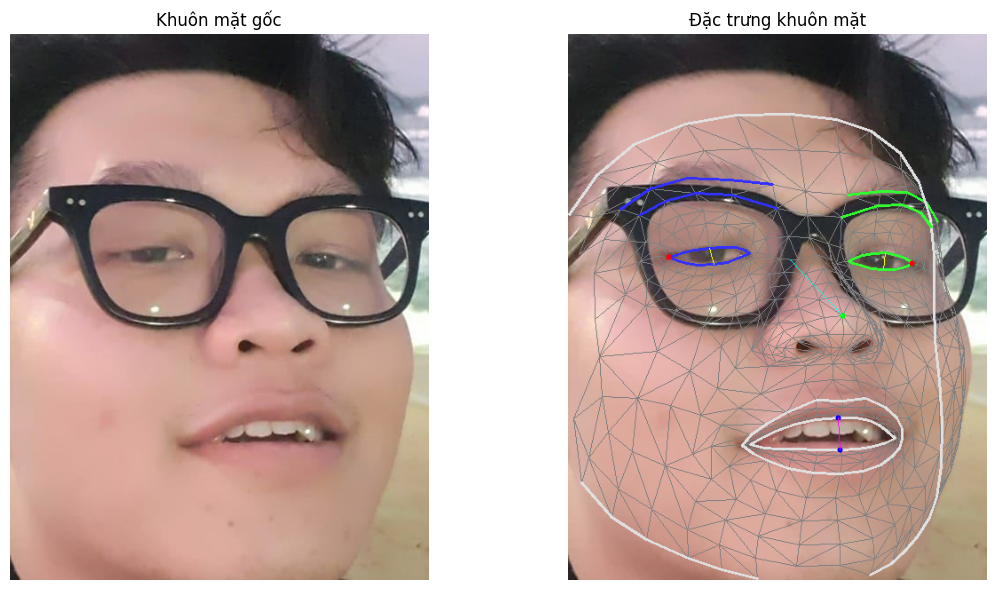

Các đặc trưng được trích xuất:
     Đặc trưng   Giá trị
0    EAR (Mắt)  0.069985
1  MAR (Miệng)  0.129468
2       Gaze X  0.689507
3       Gaze Y  0.724279


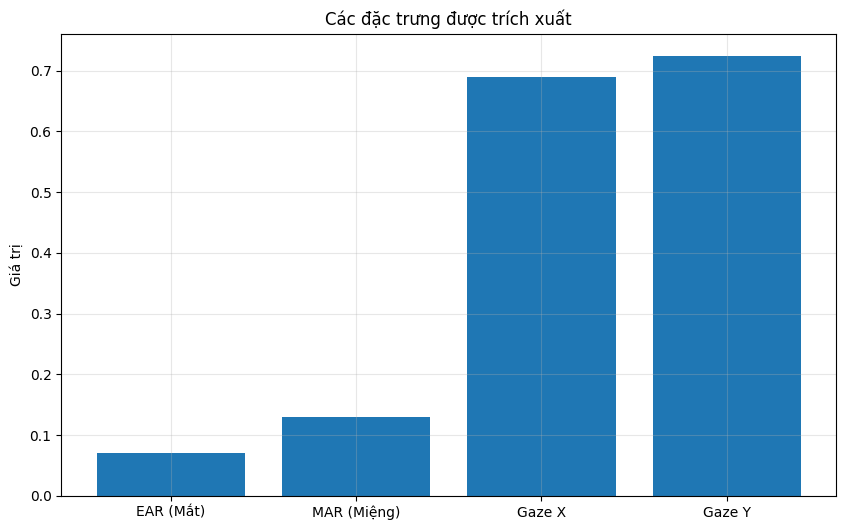

Độ chính xác: 0.9800
Báo cáo phân loại:
               precision    recall  f1-score   support

        Chú ý       0.95      1.00      0.97       217
Mất tập trung       1.00      0.94      0.97       197
     Buồn ngủ       1.00      1.00      1.00       186

     accuracy                           0.98       600
    macro avg       0.98      0.98      0.98       600
 weighted avg       0.98      0.98      0.98       600


Phân loại trạng thái chú ý: Mất tập trung
Độ tin cậy: 0.99


(array([   0.069985,     0.12947,     0.68951,     0.72428]),
 'Mất tập trung',
 0.99)

In [63]:
demo_face_features()

In [61]:
def demo_attention_monitoring_simulation():
    """
    Mô phỏng dữ liệu theo dõi sự chú ý qua thời gian và phân tích
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from datetime import datetime, timedelta

    print("Mô phỏng theo dõi sự chú ý của học sinh trong một tiết học (45 phút)")

    # Tạo dữ liệu mô phỏng
    np.random.seed(42)  # Đảm bảo kết quả có thể tái tạo

    # Thời gian mô phỏng (45 phút, mỗi bước 1 giây)
    n_steps = 45 * 60

    # Ma trận chuyển đổi trạng thái (các trạng thái có xu hướng duy trì)
    # 0: Chú ý, 1: Mất tập trung, 2: Buồn ngủ, 3: Vắng mặt
    transition_matrix = np.array([
        [0.985, 0.01, 0.004, 0.001],  # Từ Chú ý
        [0.02, 0.97, 0.008, 0.002],   # Từ Mất tập trung
        [0.01, 0.03, 0.955, 0.005],   # Từ Buồn ngủ
        [0.03, 0.02, 0.01, 0.94]      # Từ Vắng mặt
    ])

    # Trạng thái ban đầu (bắt đầu với Chú ý)
    current_state = 0

    # Khởi tạo chuỗi trạng thái
    states = []

    # Điều chỉnh mô phỏng để tạo ra đoạn thực tế hơn
    # Ở đầu tiết học (15 phút đầu): Tập trung cao
    # Giữa tiết học (15-30 phút): Dễ mất tập trung hơn
    # Cuối tiết học (30-45 phút): Dễ buồn ngủ hơn

    for i in range(n_steps):
        # Thêm trạng thái hiện tại
        states.append(current_state)

        # Điều chỉnh ma trận chuyển đổi theo thời gian
        if i < 15*60:  # 15 phút đầu
            tm = transition_matrix.copy()
        elif i < 30*60:  # 15-30 phút
            tm = transition_matrix.copy()
            # Tăng khả năng mất tập trung
            tm[0, 1] = 0.03  # Từ chú ý -> mất tập trung
            tm[0, 0] = 0.965  # Điều chỉnh lại để tổng = 1
        else:  # 30-45 phút
            tm = transition_matrix.copy()
            # Tăng khả năng buồn ngủ
            tm[0, 2] = 0.02  # Từ chú ý -> buồn ngủ
            tm[1, 2] = 0.02  # Từ mất tập trung -> buồn ngủ
            tm[0, 0] = 0.969  # Điều chỉnh lại
            tm[1, 1] = 0.958  # Điều chỉnh lại

        # Quyết định trạng thái tiếp theo dựa trên ma trận chuyển đổi
        current_state = np.random.choice(4, p=tm[current_state])

    # Tạo DataFrame
    start_time = datetime.now().replace(hour=8, minute=0, second=0, microsecond=0)  # 8:00 AM
    timestamps = [start_time + timedelta(seconds=i) for i in range(n_steps)]
    state_names = ['Chú ý', 'Mất tập trung', 'Buồn ngủ', 'Vắng mặt']

    df = pd.DataFrame({
        'timestamp': timestamps,
        'state_id': states,
        'state': [state_names[s] for s in states]
    })

    # Tính toán thời lượng cho mỗi đoạn trạng thái liên tục
    df['segment'] = (df['state_id'] != df['state_id'].shift()).cumsum()

    # Tính tổng thời gian cho mỗi trạng thái
    state_durations = df.groupby('state').size()
    state_percentages = (state_durations / state_durations.sum() * 100).round(2)

    # Tính thời gian trung bình cho mỗi đoạn trạng thái liên tục
    segment_durations = df.groupby(['segment', 'state']).size().reset_index(name='duration')
    avg_segment_durations = segment_durations.groupby('state')['duration'].mean().round(2)

    # Tính số lần chuyển đổi trạng thái
    transitions = len(segment_durations) - 1

    # Tạo báo cáo
    print("\n===== BÁO CÁO MÔ PHỎNG THEO DÕI SỰ CHÚ Ý =====")
    print(f"Tổng thời gian mô phỏng: 45 phút ({n_steps} giây)")
    print(f"Số lần chuyển đổi trạng thái: {transitions}")

    print("\nTỷ lệ thời gian cho mỗi trạng thái:")
    for state, percentage in state_percentages.items():
        print(f"  - {state}: {percentage:.2f}%")

    print("\nThời gian trung bình cho mỗi đoạn trạng thái liên tục (giây):")
    for state, duration in avg_segment_durations.items():
        minutes = int(duration // 60)
        seconds = int(duration % 60)
        print(f"  - {state}: {minutes}m {seconds}s")

    # Trực quan hóa kết quả
    colors = ['green', 'orange', 'red', 'gray']

    # 1. Biểu đồ tỷ lệ thời gian
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)
    plt.pie(state_percentages, labels=state_percentages.index, colors=colors,
            autopct='%1.1f%%', startangle=90)
    plt.title('Tỷ lệ thời gian cho mỗi trạng thái', fontsize=14)

    # 2. Biểu đồ thời gian trung bình cho mỗi đoạn
    plt.subplot(2, 2, 2)
    states = list(avg_segment_durations.index)
    durations = list(avg_segment_durations.values)
    color_dict = dict(zip(['Chú ý', 'Mất tập trung', 'Buồn ngủ', 'Vắng mặt'], colors))
    bar_colors = [color_dict.get(state, 'gray') for state in states]

    plt.bar(states, durations, color=bar_colors)
    plt.xlabel('Trạng thái')
    plt.ylabel('Thời gian trung bình (giây)')
    plt.title('Thời gian trung bình mỗi đoạn trạng thái liên tục', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')

    # 3. Biểu đồ trạng thái theo thời gian
    plt.subplot(2, 1, 2)

    # Map states to numbers for plotting
    state_map = {'Chú ý': 3, 'Mất tập trung': 2, 'Buồn ngủ': 1, 'Vắng mặt': 0}
    df['state_value'] = df['state'].map(lambda s: state_map.get(s, 0))

    # Vẽ dữ liệu theo thời gian
    elapsed_times = [(ts - start_time).total_seconds() / 60 for ts in df['timestamp']]  # Chuyển sang phút
    plt.scatter(elapsed_times, df['state_value'], c=[color_dict.get(s, 'gray') for s in df['state']],
               s=30, alpha=0.7)

    # Thêm đường nối các điểm
    for state_val in range(4):
        mask = (df['state_value'] == state_val)
        if mask.any():
            plt.plot(np.array(elapsed_times)[mask], np.array(df['state_value'])[mask],
                    color=colors[3-state_val], alpha=0.5, linestyle='-')

    # Cấu hình trục và tiêu đề
    plt.yticks([0, 1, 2, 3], ['Vắng mặt', 'Buồn ngủ', 'Mất tập trung', 'Chú ý'])
    plt.xlabel('Thời gian (phút)')
    plt.ylabel('Trạng thái')
    plt.title('Trạng thái chú ý theo thời gian', fontsize=14)
    plt.grid(True, alpha=0.3)


    # Define end_time here
    end_time = start_time + timedelta(seconds=n_steps)

    # Thêm ghi chú
    elapsed_total = (end_time - start_time).total_seconds() / 60  # Tổng thời gian theo phút
    xticks = np.arange(0, elapsed_total, max(1, elapsed_total//10))  # Mỗi 1/10 thời gian
    plt.xticks(xticks)

    plt.tight_layout()
    plt.show()

    # Biểu đồ chuyển đổi trạng thái
    if len(df) > 1:
        plt.figure(figsize=(12, 8))

        # Tính toán số lần chuyển đổi giữa các trạng thái
        transitions = np.zeros((4, 4))
        state_indices = {'Chú ý': 0, 'Mất tập trung': 1, 'Buồn ngủ': 2, 'Vắng mặt': 3}

        for i in range(1, len(df)):
            prev_state = df['state'].iloc[i-1]
            curr_state = df['state'].iloc[i]

            if prev_state in state_indices and curr_state in state_indices:
                prev_idx = state_indices[prev_state]
                curr_idx = state_indices[curr_state]
                transitions[prev_idx, curr_idx] += 1

        # Tạo biểu đồ chuyển đổi
        import seaborn as sns
        plt.figure(figsize=(10, 8))
        sns.heatmap(transitions, annot=True, fmt='.0f', cmap='Blues',
                   xticklabels=list(state_indices.keys()),
                   yticklabels=list(state_indices.keys()))
        plt.title('Ma trận chuyển đổi trạng thái')
        plt.xlabel('Trạng thái tiếp theo')
        plt.ylabel('Trạng thái hiện tại')
        plt.tight_layout()
        plt.show()

    return df

Mô phỏng theo dõi sự chú ý của học sinh trong một tiết học (45 phút)

===== BÁO CÁO MÔ PHỎNG THEO DÕI SỰ CHÚ Ý =====
Tổng thời gian mô phỏng: 45 phút (2700 giây)
Số lần chuyển đổi trạng thái: 80

Tỷ lệ thời gian cho mỗi trạng thái:
  - Buồn ngủ: 21.59%
  - Chú ý: 41.63%
  - Mất tập trung: 35.19%
  - Vắng mặt: 1.59%

Thời gian trung bình cho mỗi đoạn trạng thái liên tục (giây):
  - Buồn ngủ: 0m 26s
  - Chú ý: 0m 44s
  - Mất tập trung: 0m 30s
  - Vắng mặt: 0m 14s


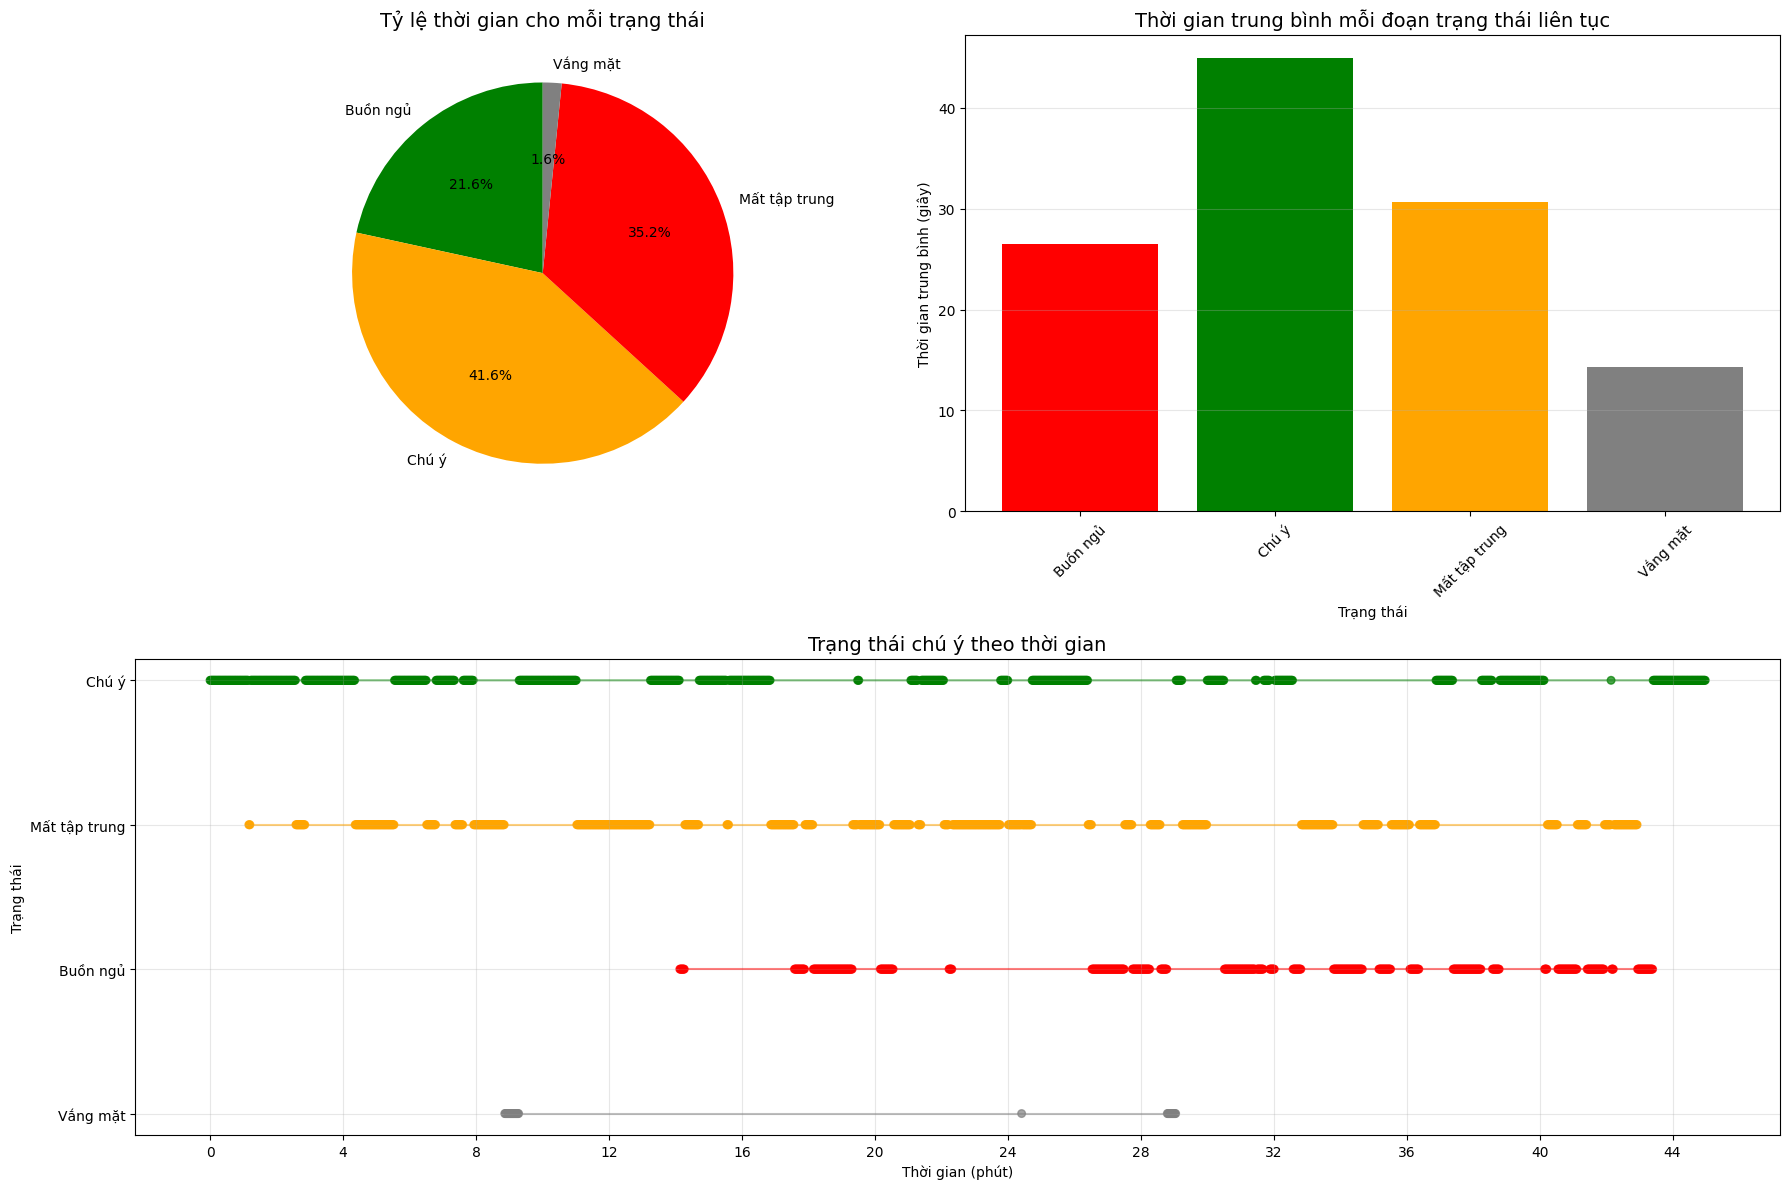

<Figure size 1200x800 with 0 Axes>

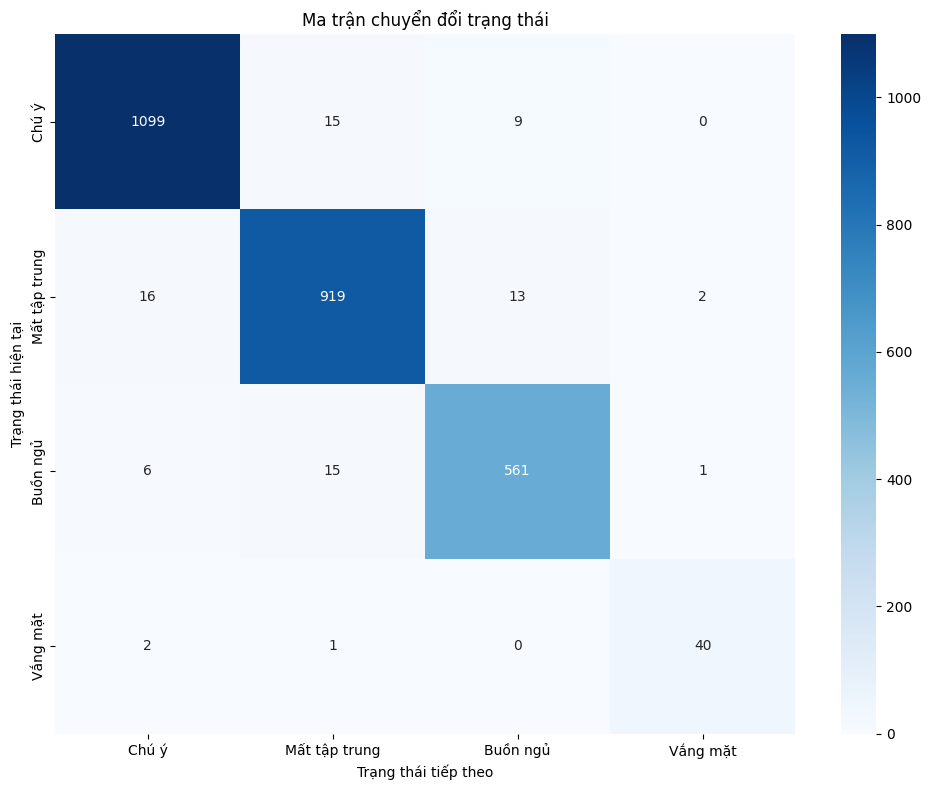

timestamp  state_id  state  segment  state_value
0    2025-03-28 08:00:00         0  Chú ý        1            3
1    2025-03-28 08:00:01         0  Chú ý        1            3
2    2025-03-28 08:00:02         0  Chú ý        1            3
3    2025-03-28 08:00:03         0  Chú ý        1            3
4    2025-03-28 08:00:04         0  Chú ý        1            3
...                  ...       ...    ...      ...          ...
2695 2025-03-28 08:44:55         0  Chú ý       81            3
2696 2025-03-28 08:44:56         0  Chú ý       81            3
2697 2025-03-28 08:44:57         0  Chú ý       81            3
2698 2025-03-28 08:44:58         0  Chú ý       81            3
2699 2025-03-28 08:44:59         0  Chú ý       81            3

[2700 rows x 5 columns]

In [62]:
demo_attention_monitoring_simulation()